
# 📊 Telecom X - Análise de Evasão de Clientes

Você foi contratado como assistente de análise de dados na **Telecom X** para colaborar no projeto **Churn de Clientes**, que visa compreender os principais motivos de cancelamento e propor estratégias para **reduzir a evasão**.

Neste projeto, utilizaremos Python e suas principais bibliotecas para coletar, tratar e analisar dados. A partir da sua análise, outros membros da equipe seguirão com a construção de modelos preditivos.

### 🧠 O que será praticado:
✅ Importar e manipular dados via API  
✅ Aplicar os conceitos de **ETL**  
✅ Criar **visualizações estratégicas**  
✅ Conduzir uma **Análise Exploratória de Dados (EDA)**  



## 🔄 O que é ETL?

**ETL** é o processo de **Extração, Transformação e Carga** de dados. Ele garante que os dados sejam:

- 🔍 Coletados de forma confiável (extração)  
- 🛠️ Limpados, corrigidos e estruturados (transformação)  
- 💾 Armazenados de forma organizada e prontos para uso (carga)

Esse processo é essencial para garantir **qualidade**, **reprodutibilidade** e **valor estratégico** na análise de dados.



## 📥 Etapa E – Extração dos Dados

**Objetivo:** carregar os dados da API (JSON) da Telecom X a partir do link *raw* do GitHub, validar a resposta e criar uma cópia local dos dados brutos.

**Entradas:**
- Link raw da API:  
  https://raw.githubusercontent.com/ingridcristh/challenge2-data-science/main/TelecomX_Data.json

**Saídas:**
- `df_raw` (DataFrame com os dados brutos)  
- Arquivo salvo em `data/raw/TelecomX_Data.json` (cópia local)


In [62]:
# Importando bibliotecas necessárias

import os
from pathlib import Path
import io, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# # Verifica se o pacote 'requests' está instalado
# try:
#     import requests
#     HAS_REQUESTS = True
# except ImportError:
#     HAS_REQUESTS = False


# # Configurações do display do Pandas
# pd.set_option("display.max_columns", 100)
# pd.set_option("display.width", 120)

# # Cria diretório local para salvar o json bruto
# RAW_DIR = Path("data/raw")
# RAW_DIR.mkdir(parents=True, exist_ok=True)

# # URL de origem
# DATA_URL_RAW = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science/main/TelecomX_Data.json"
# LOCAL_RAW_PATH = RAW_DIR / "TelecomX_Data.json"

# # Extração
# if not HAS_REQUESTS:
#     raise ImportError("O pacote 'requests' é necessário para a etapa de extração.")

# resp = requests.get(DATA_URL_RAW, timeout=30)
# print("Status HTTP:", resp.status_code)
# resp.raise_for_status()

# # Conversão em DataFrame
# try:
#     df_raw = pd.read_json(io.StringIO(resp.text))
# except ValueError:
#     data = json.loads(resp.text)
#     df_raw = pd.DataFrame(data)

# # Garantias
# assert isinstance(df_raw, pd.DataFrame), "Erro: dados não são DataFrame"
# assert not df_raw.empty, "Erro: DataFrame vazio após leitura"

# # Salvar localmente
# LOCAL_RAW_PATH.write_text(resp.text, encoding="utf-8")
# print("Arquivo salvo em:", LOCAL_RAW_PATH.resolve())

# # Exibir amostra
# print("Shape:", df_raw.shape)

# # Exibir informações do DataFrame
# df_raw.info(verbose=True)
# df_raw.head()


Status HTTP: 200
Arquivo salvo em: D:\Users\rodri\Documents\ONE + Alura\ONE G8\Challenges\challenge-telecomX\data\raw\TelecomX_Data.json
Shape: (7267, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   customerID  7267 non-null   object
 1   Churn       7267 non-null   object
 2   customer    7267 non-null   object
 3   phone       7267 non-null   object
 4   internet    7267 non-null   object
 5   account     7267 non-null   object
dtypes: object(6)
memory usage: 340.8+ KB


,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."



## 🔧 Etapa T – Transformação dos Dados

Nesta fase, vamos:

- Normalizar os payloads (`customer`, `phone`, `internet`, `account`)  
- Corrigir inconsistências, valores ausentes e formatação  
- Aplicar padronizações com Regex  
- Criar variáveis úteis para análise (ex: `has_internet`, `Contas_Diarias`)  


In [64]:
# Normalização de colunas de payload
df_t = df_raw.copy() 

# Função para expandir colunas de payload
def expand_payload(df, source_col, prefix):
    if source_col not in df.columns:
        return df
    payload_df = pd.json_normalize(df[source_col]) 
    payload_df = payload_df.add_prefix(f"{prefix}_")
    df = pd.concat([df.drop(columns=[source_col]), payload_df], axis=1) 
    return df

# Expandir
for col in ["customer", "phone", "internet", "account"]:
    df_t = expand_payload(df_t, col, col)

# Corrigir nomes de colunas (pontos → underscores)
df_t.columns = df_t.columns.str.replace(r"[\.]", "_", regex=True)

print("Shape após normalização:", df_t.shape)

# Exibir informações do DataFrame
display(df_t.info(verbose=True)) 
df_t.head()


Shape após normalização: (7267, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7267 non-null   object 
 2   customer_gender            7267 non-null   object 
 3   customer_SeniorCitizen     7267 non-null   int64  
 4   customer_Partner           7267 non-null   object 
 5   customer_Dependents        7267 non-null   object 
 6   customer_tenure            7267 non-null   int64  
 7   phone_PhoneService         7267 non-null   object 
 8   phone_MultipleLines        7267 non-null   object 
 9   internet_InternetService   7267 non-null   object 
 10  internet_OnlineSecurity    7267 non-null   object 
 11  internet_OnlineBackup      7267 non-null   object 
 12  internet_DeviceProtection  7267 non-null   object 
 13  internet_Tec

None

,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,internet_OnlineSecurity,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges_Monthly,account_Charges_Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


## 🧪 Inspeções Iniciais dos Dados

Antes de prosseguirmos com o processo de transformação e análise dos dados, é fundamental realizar uma série de inspeções iniciais. Estas verificações têm o objetivo de garantir a **qualidade**, **consistência** e **confiabilidade** dos dados que serão utilizados nas próximas etapas do projeto.

Abaixo estão as inspeções que serão conduzidas:

### 1️⃣ Verificação de Linhas Duplicadas

- **Objetivo**: Identificar se existem registros idênticos no dataset.
- **Impacto**: Linhas duplicadas podem enviesar análises estatísticas e inferências.
- **Ação**: Caso existam, podem ser removidas dependendo do contexto.

In [65]:
# Verificar se há linhas duplicadas
duplicadas = df_t.duplicated()
print(f"🔁 Linhas duplicadas: {duplicadas.sum()}")

# Exibir linhas duplicadas (se houver)
if duplicadas.sum() > 0:
    display(df_t[duplicadas])


🔁 Linhas duplicadas: 0


### 2️⃣ Detecção de Valores Ausentes (Nulos, `NaN`, `NA`)

- **Objetivo**: Verificar a existência de valores faltantes em qualquer coluna.
- **Impacto**: Valores ausentes podem prejudicar modelos preditivos e análises descritivas.
- **Ação**: Realizar tratamento adequado (remoção, imputação ou categorização como valor ausente).


In [66]:
# Verifica valores ausentes em cada coluna
na_counts = df_t.isna().sum()
na_percent = (na_counts / len(df_t)) * 100

# Exibe resultado em formato tabular
missing_df = pd.DataFrame({
    "Valores Ausentes": na_counts,
    "Percentual (%)": na_percent.round(2)
})
display(missing_df[missing_df["Valores Ausentes"] > 0].sort_values(by="Valores Ausentes", ascending=False))


,Valores Ausentes,Percentual (%)


### 3️⃣ Identificação de Valores Não Numéricos

- **Objetivo**: Avaliar colunas que **deveriam conter apenas números** (ex: totais, gastos, tempo) e verificar se há textos, símbolos ou outros formatos incorretos.
- **Impacto**: Pode impedir a conversão de tipos e gerar erros ao tentar aplicar funções matemáticas.
- **Ação**: Tratar ou remover os registros incorretos, padronizando os formatos.

In [67]:
# Verifica em todas as colunas se existem valores não numéricos (para colunas que deveriam conter apenas números)

print("📌 Verificação de valores não numéricos em todo o DataFrame:\n")

for col in df_t.columns:
    # Verifica se é uma coluna do tipo object ou se pode conter valores mistos
    if df_t[col].dtype == "object":
        print(f"\n🔍 Coluna: {col}")
        
        # Converte para string, remove espaços e verifica se bate com padrão numérico
        invalid_entries = df_t[
            ~df_t[col].astype(str).str.strip().str.match(r"^\d+(\.\d+)?$", na=False)
        ][col].unique()

        if len(invalid_entries) > 0:
            print(f"❗ Valores não numéricos encontrados: {invalid_entries}")
        else:
            print("✅ Nenhum valor suspeito encontrado.")


📌 Verificação de valores não numéricos em todo o DataFrame:


🔍 Coluna: customerID
❗ Valores não numéricos encontrados: ['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']

🔍 Coluna: Churn
❗ Valores não numéricos encontrados: ['No' 'Yes' '']

🔍 Coluna: customer_gender
❗ Valores não numéricos encontrados: ['Female' 'Male']

🔍 Coluna: customer_Partner
❗ Valores não numéricos encontrados: ['Yes' 'No']

🔍 Coluna: customer_Dependents
❗ Valores não numéricos encontrados: ['Yes' 'No']

🔍 Coluna: phone_PhoneService
❗ Valores não numéricos encontrados: ['Yes' 'No']

🔍 Coluna: phone_MultipleLines
❗ Valores não numéricos encontrados: ['No' 'Yes' 'No phone service']

🔍 Coluna: internet_InternetService
❗ Valores não numéricos encontrados: ['DSL' 'Fiber optic' 'No']

🔍 Coluna: internet_OnlineSecurity
❗ Valores não numéricos encontrados: ['No' 'Yes' 'No internet service']

🔍 Coluna: internet_OnlineBackup
❗ Valores não numéricos encontrados: ['Yes' 'No' 'No internet se

In [68]:
# 🔍 Identifica linhas com valores vazios do tipo '' ou ' '
mask_empty_values = df_t.applymap(lambda x: isinstance(x, str) and x.strip() == "")
rows_with_empty = df_t[mask_empty_values.any(axis=1)]

# Exibe as linhas com problemas
print(f"Total de linhas com valores vazios ('', ' '): {rows_with_empty.shape[0]}")
display(rows_with_empty)


C:\Users\Acer\AppData\Local\Temp\ipykernel_28516\1110162192.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mask_empty_values = df_t.applymap(lambda x: isinstance(x, str) and x.strip() == "")


Total de linhas com valores vazios ('', ' '): 235


,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,internet_OnlineSecurity,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges_Monthly,account_Charges_Total
30,0047-ZHDTW,,Female,0,No,No,11,Yes,Yes,Fiber optic,Yes,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),79.00,929.3
75,0120-YZLQA,,Male,0,No,No,71,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Credit card (automatic),19.90,1355.1
96,0154-QYHJU,,Male,0,No,No,29,Yes,No,DSL,Yes,Yes,No,Yes,No,No,One year,Yes,Electronic check,58.75,1696.2
98,0162-RZGMZ,,Female,1,No,No,5,Yes,No,DSL,Yes,Yes,No,Yes,No,No,Month-to-month,No,Credit card (automatic),59.90,287.85
175,0274-VVQOQ,,Male,1,Yes,No,65,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Bank transfer (automatic),103.15,6792.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7158,9840-GSRFX,,Female,0,No,No,14,Yes,Yes,DSL,No,Yes,No,No,No,No,One year,Yes,Mailed check,54.25,773.2
7180,9872-RZQQB,,Female,0,Yes,No,49,No,No phone service,DSL,Yes,No,No,No,Yes,No,Month-to-month,No,Bank transfer (automatic),40.65,2070.75
7211,9920-GNDMB,,Male,0,No,No,9,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,76.25,684.85
7239,9955-RVWSC,,Female,0,Yes,Yes,67,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),19.25,1372.9


In [69]:
# 🧹 Remove linhas com valores '' ou ' '
df_t = df_t[~mask_empty_values.any(axis=1)]

# Verifica resultado
print(f"Novo shape após remoção: {df_t.shape}")


Novo shape após remoção: (7032, 21)


### 4️⃣ Verificação de Tipos de Dados

- **Objetivo**: Certificar que os tipos atribuídos a cada coluna estão corretos (`float`, `int`, `object`, etc.).
- **Impacto**: Tipos incorretos podem causar falhas na transformação, modelagem e visualização.
- **Ação**: Ajustar os tipos conforme o contexto da variável.

In [70]:
# Exibir tipos de dados de cada coluna
print("📋 Tipos de dados por coluna:")
display(df_t.dtypes.to_frame("Tipo").sort_index())


📋 Tipos de dados por coluna:


,Tipo
Churn,object
account_Charges_Monthly,float64
account_Charges_Total,object
account_Contract,object
account_PaperlessBilling,object
account_PaymentMethod,object
customerID,object
customer_Dependents,object
customer_Partner,object
customer_SeniorCitizen,int64


### 5️⃣ Avaliação de Colunas com Baixa Variabilidade ou Altamente Desequilibradas

- **Objetivo**: Detectar colunas que têm um único valor dominante ou pouca variabilidade.
- **Impacto**: Essas colunas podem ser irrelevantes para o modelo e distorcer a análise.
- **Ação**: Avaliar caso a caso se devem ser mantidas ou descartadas.

In [71]:
# Exibir colunas com menos de 3 valores únicos
print("📉 Colunas com baixa variabilidade:")
for col in df_t.columns:
    n_unique = df_t[col].nunique()
    if n_unique < 3:
        print(f" - {col}: {n_unique} valor(es) único(s)")


📉 Colunas com baixa variabilidade:
 - Churn: 2 valor(es) único(s)
 - customer_gender: 2 valor(es) único(s)
 - customer_SeniorCitizen: 2 valor(es) único(s)
 - customer_Partner: 2 valor(es) único(s)
 - customer_Dependents: 2 valor(es) único(s)
 - phone_PhoneService: 2 valor(es) único(s)
 - account_PaperlessBilling: 2 valor(es) único(s)


### 🧼 Padronização e Conversão de Dados Textuais

Nesta etapa, realizamos a limpeza e padronização de colunas categóricas e a conversão de colunas numéricas que estavam no formato de texto:

- **Padronização de colunas categóricas (`object`)**:
  - Remoção de espaços extras com `.strip()` e conversão para minúsculas com `.lower()`, garantindo consistência na codificação dos valores categóricos.

- **Correção de colunas numéricas importadas como texto**:
  - As colunas `account_Charges_Total` e `account_Charges_Monthly` foram inicialmente carregadas como texto (`object`) por conterem símbolos ou caracteres não numéricos.
  - Usamos expressões regulares para remover tudo que não fosse número ou ponto decimal (`[^\d\.]`), substituímos strings vazias por `NaN`, e convertemos o tipo para `float`.

- **Verificações finais**:
  - Utilizamos `df_t.info()` para confirmar os tipos de dados após a transformação.
  - Exibimos as primeiras linhas com `df_t.head()` para validar visualmente o resultado da limpeza.

Essa etapa é fundamental para garantir que as análises estatísticas e os modelos posteriores operem com dados consistentes e limpos.


In [72]:
# 🧼 Limpeza e padronização de colunas textuais (object)
obj_cols = df_t.select_dtypes(include="object").columns

# Aplica strip() e lower() nas colunas categóricas
df_t[obj_cols] = df_t[obj_cols].apply(
    lambda s: s.str.strip().str.lower() if s.dtype == "object" else s
)

# 🔢 Correção de números que vieram como texto (account_Charges)
df_t["account_Charges_Total"] = (
    df_t["account_Charges_Total"]
      .astype(str)
      .str.replace(r"[^\d\.]", "", regex=True)
      .replace("", np.nan) 
      .astype(float)
)

df_t["account_Charges_Monthly"] = (
    df_t["account_Charges_Monthly"]
      .astype(str)
      .str.replace(r"[^\d\.]", "", regex=True)
      .replace("", np.nan) 
      .astype(float)
)

# Verificar colunas e tipos
display(df_t.info(verbose=True)) 

# Exibir as primeiras linhas do DataFrame
display(df_t.head(5)) 

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7032 non-null   object 
 1   Churn                      7032 non-null   object 
 2   customer_gender            7032 non-null   object 
 3   customer_SeniorCitizen     7032 non-null   int64  
 4   customer_Partner           7032 non-null   object 
 5   customer_Dependents        7032 non-null   object 
 6   customer_tenure            7032 non-null   int64  
 7   phone_PhoneService         7032 non-null   object 
 8   phone_MultipleLines        7032 non-null   object 
 9   internet_InternetService   7032 non-null   object 
 10  internet_OnlineSecurity    7032 non-null   object 
 11  internet_OnlineBackup      7032 non-null   object 
 12  internet_DeviceProtection  7032 non-null   object 
 13  internet_TechSupport       7032 non-null   object 
 1

None

,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,internet_OnlineSecurity,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges_Monthly,account_Charges_Total
0,0002-orfbo,no,female,0,yes,yes,9,yes,no,dsl,no,yes,no,yes,yes,no,one year,yes,mailed check,65.6,593.30
1,0003-mknfe,no,male,0,no,no,9,yes,yes,dsl,no,no,no,no,no,yes,month-to-month,no,mailed check,59.9,542.40
2,0004-tlhlj,yes,male,0,no,no,4,yes,no,fiber optic,no,no,yes,no,no,no,month-to-month,yes,electronic check,73.9,280.85
3,0011-igkff,yes,male,1,yes,no,13,yes,no,fiber optic,no,yes,yes,no,yes,yes,month-to-month,yes,electronic check,98.0,1237.85
4,0013-exchz,yes,female,1,yes,no,3,yes,no,fiber optic,no,no,no,yes,yes,no,month-to-month,yes,mailed check,83.9,267.40


### 📊 Análise de Cardinalidade das Variáveis

Nesta etapa, vamos verificar a **cardinalidade** das variáveis do dataset, ou seja, a quantidade de **valores únicos** por coluna.  
Isso nos ajuda a:

- Identificar variáveis **binárias** (como "sim/não", "masculino/feminino")
- Detectar variáveis **multicategróricas**, que podem exigir tratamento especial (ex: one-hot encoding)
- Avaliar colunas com **alta cardinalidade**, como `customerID`, que não são úteis para modelagem
- Verificar possíveis colunas com valores únicos e inconsistências restantes

A partir desta análise, poderemos **classificar e tomar decisões** sobre o tratamento adequado para cada variável.


In [73]:
# 📊 Verificando a cardinalidade (valores únicos) por coluna
cardinalidade = (
    df_t.nunique(dropna=True)
    .sort_values(ascending=False)
    .to_frame(name="valores_únicos")
)

# Classifica tipo de cardinalidade
cardinalidade["tipo"] = pd.cut(
    cardinalidade["valores_únicos"],
    bins=[0, 2, 10, 50, 1000, np.inf],
    labels=["binária", "baixa", "média", "alta", "muito alta"]
)

# Exibe as variáveis com maior e menor cardinalidade
print("🔝 Cardinalidade em ordem decrescente:")
display(cardinalidade)

# print("\n🔽 Top 10 colunas com menor cardinalidade:")
# display(cardinalidade.tail(100))

# Visão geral da distribuição
print("\n📌 Distribuição geral das categorias:")
display(cardinalidade["tipo"].value_counts().to_frame("quantidade"))


🔝 Cardinalidade em ordem decrescente:


,valores_únicos,tipo
customerID,7032,muito alta
account_Charges_Total,6530,muito alta
account_Charges_Monthly,1584,muito alta
customer_tenure,72,alta
account_PaymentMethod,4,baixa
account_Contract,3,baixa
internet_StreamingMovies,3,baixa
internet_DeviceProtection,3,baixa
internet_TechSupport,3,baixa
internet_OnlineBackup,3,baixa



📌 Distribuição geral das categorias:


,quantidade
tipo,
baixa,10
binária,7
muito alta,3
alta,1
média,0


### 🛠️ Codificação das Variáveis Categóricas

Com base na análise de cardinalidade:

- As variáveis **binárias** (com dois valores únicos) serão convertidas para o formato numérico `0` e `1`, facilitando análises e modelos.
- As variáveis **multicategóricas de baixa cardinalidade** serão avaliadas para aplicação de codificação por dummies (One-Hot Encoding), mantendo a interpretabilidade.
- As variáveis com **alta ou muito alta cardinalidade** não serão transformadas nesta etapa, pois podem não ser úteis diretamente ou exigem tratamento específico.

Esse processo torna os dados mais consistentes e adequados para análises quantitativas e modelagem preditiva.


In [74]:
# ✅ Mapeamento binário para yes/no, male/female
bin_map = {
    "yes": 1,
    "no": 0,
    "male": 1,
    "female": 0
}

# 🔹 Colunas binárias (incluindo 'Churn')
bin_cols = [
    "customer_gender",
    "customer_SeniorCitizen",
    "customer_Partner",
    "customer_Dependents",
    "phone_PhoneService",
    "account_PaperlessBilling",
    "Churn"  # variável-alvo
]

# Aplica o mapeamento
df_t[bin_cols] = df_t[bin_cols].replace(bin_map)

# 🔁 Renomeia para refletir o significado do valor 1
df_t.rename(columns={
    "customer_gender": "customer_gender_is_Male",
    "customer_SeniorCitizen": "customer_is_SeniorCitizen",
    "customer_Partner": "customer_has_Partner",
    "customer_Dependents": "customer_has_Dependents",
    "phone_PhoneService": "phone_has_PhoneService",
    "account_PaperlessBilling": "account_is_PaperlessBilling"
    # 'Churn' mantido como está
}, inplace=True)

# Verificação
print("✅ Codificação binária aplicada com sucesso:")

# Exibir as primeiras linhas do DataFrame com colunas binárias
display(df_t.head())

# Verificar colunas e tipos
display(df_t.info(verbose=True))


✅ Codificação binária aplicada com sucesso:


C:\Users\Acer\AppData\Local\Temp\ipykernel_28516\295796550.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_t[bin_cols] = df_t[bin_cols].replace(bin_map)


,customerID,Churn,customer_gender_is_Male,customer_is_SeniorCitizen,customer_has_Partner,customer_has_Dependents,customer_tenure,phone_has_PhoneService,phone_MultipleLines,internet_InternetService,internet_OnlineSecurity,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_is_PaperlessBilling,account_PaymentMethod,account_Charges_Monthly,account_Charges_Total
0,0002-orfbo,0,0,0,1,1,9,1,no,dsl,no,yes,no,yes,yes,no,one year,1,mailed check,65.6,593.30
1,0003-mknfe,0,1,0,0,0,9,1,yes,dsl,no,no,no,no,no,yes,month-to-month,0,mailed check,59.9,542.40
2,0004-tlhlj,1,1,0,0,0,4,1,no,fiber optic,no,no,yes,no,no,no,month-to-month,1,electronic check,73.9,280.85
3,0011-igkff,1,1,1,1,0,13,1,no,fiber optic,no,yes,yes,no,yes,yes,month-to-month,1,electronic check,98.0,1237.85
4,0013-exchz,1,0,1,1,0,3,1,no,fiber optic,no,no,no,yes,yes,no,month-to-month,1,mailed check,83.9,267.40


<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   customerID                   7032 non-null   object 
 1   Churn                        7032 non-null   int64  
 2   customer_gender_is_Male      7032 non-null   int64  
 3   customer_is_SeniorCitizen    7032 non-null   int64  
 4   customer_has_Partner         7032 non-null   int64  
 5   customer_has_Dependents      7032 non-null   int64  
 6   customer_tenure              7032 non-null   int64  
 7   phone_has_PhoneService       7032 non-null   int64  
 8   phone_MultipleLines          7032 non-null   object 
 9   internet_InternetService     7032 non-null   object 
 10  internet_OnlineSecurity      7032 non-null   object 
 11  internet_OnlineBackup        7032 non-null   object 
 12  internet_DeviceProtection    7032 non-null   object 
 13  internet_TechSupport   

None

In [75]:
# Lista de colunas já renomeadas (depois do rename)
colunas_binarias_finais = [
    "customer_gender_is_Male",
    "customer_is_SeniorCitizen",
    "customer_has_Partner",
    "customer_has_Dependents",
    "phone_has_PhoneService",
    "account_is_PaperlessBilling",
    "Churn"
]

# Verificação: valores únicos por coluna + tipo
print("✅ Verificando se as colunas estão corretamente codificadas (valores e tipos):\n")
for col in colunas_binarias_finais:
    unicos = df_t[col].dropna().unique()
    tipo = df_t[col].dtype
    print(f"- {col}: únicos={list(unicos)}, tipo={tipo}")


✅ Verificando se as colunas estão corretamente codificadas (valores e tipos):

- customer_gender_is_Male: únicos=[np.int64(0), np.int64(1)], tipo=int64
- customer_is_SeniorCitizen: únicos=[np.int64(0), np.int64(1)], tipo=int64
- customer_has_Partner: únicos=[np.int64(1), np.int64(0)], tipo=int64
- customer_has_Dependents: únicos=[np.int64(1), np.int64(0)], tipo=int64
- phone_has_PhoneService: únicos=[np.int64(1), np.int64(0)], tipo=int64
- account_is_PaperlessBilling: únicos=[np.int64(1), np.int64(0)], tipo=int64
- Churn: únicos=[np.int64(0), np.int64(1)], tipo=int64


In [76]:
# 🔄 Corrige possíveis strings vazias antes da conversão
for col in colunas_binarias_finais:
    df_t[col] = df_t[col].replace({"": pd.NA})

# ✅ Agora sim, podemos forçar o tipo Int64
df_t[colunas_binarias_finais] = df_t[colunas_binarias_finais].astype("Int64")

# Verificação
print("✅ Tipos após padronização:")
print(df_t[colunas_binarias_finais].dtypes)

# Exibir as primeiras linhas do DataFrame com colunas binárias
display(df_t.head())

# Verificar colunas e tipos
display(df_t.info(verbose=True))


✅ Tipos após padronização:
customer_gender_is_Male        Int64
customer_is_SeniorCitizen      Int64
customer_has_Partner           Int64
customer_has_Dependents        Int64
phone_has_PhoneService         Int64
account_is_PaperlessBilling    Int64
Churn                          Int64
dtype: object


,customerID,Churn,customer_gender_is_Male,customer_is_SeniorCitizen,customer_has_Partner,customer_has_Dependents,customer_tenure,phone_has_PhoneService,phone_MultipleLines,internet_InternetService,internet_OnlineSecurity,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_is_PaperlessBilling,account_PaymentMethod,account_Charges_Monthly,account_Charges_Total
0,0002-orfbo,0,0,0,1,1,9,1,no,dsl,no,yes,no,yes,yes,no,one year,1,mailed check,65.6,593.30
1,0003-mknfe,0,1,0,0,0,9,1,yes,dsl,no,no,no,no,no,yes,month-to-month,0,mailed check,59.9,542.40
2,0004-tlhlj,1,1,0,0,0,4,1,no,fiber optic,no,no,yes,no,no,no,month-to-month,1,electronic check,73.9,280.85
3,0011-igkff,1,1,1,1,0,13,1,no,fiber optic,no,yes,yes,no,yes,yes,month-to-month,1,electronic check,98.0,1237.85
4,0013-exchz,1,0,1,1,0,3,1,no,fiber optic,no,no,no,yes,yes,no,month-to-month,1,mailed check,83.9,267.40


<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   customerID                   7032 non-null   object 
 1   Churn                        7032 non-null   Int64  
 2   customer_gender_is_Male      7032 non-null   Int64  
 3   customer_is_SeniorCitizen    7032 non-null   Int64  
 4   customer_has_Partner         7032 non-null   Int64  
 5   customer_has_Dependents      7032 non-null   Int64  
 6   customer_tenure              7032 non-null   int64  
 7   phone_has_PhoneService       7032 non-null   Int64  
 8   phone_MultipleLines          7032 non-null   object 
 9   internet_InternetService     7032 non-null   object 
 10  internet_OnlineSecurity      7032 non-null   object 
 11  internet_OnlineBackup        7032 non-null   object 
 12  internet_DeviceProtection    7032 non-null   object 
 13  internet_TechSupport   

None

## 🔎 Análise das Variáveis Categóricas Multiclasse

Agora que padronizamos e codificamos as variáveis binárias, vamos examinar as **variáveis categóricas com múltiplas categorias** (baixa cardinalidade) para entender sua estrutura e decidir como tratá-las.

### Objetivo:
- Verificar os **valores únicos** presentes em cada variável
- Avaliar se a variável pode ser:
  - ✅ Convertida para binária (ex: "Yes" vs "No service")
  - ✅ Transformada em variáveis dummies (via one-hot encoding)
  - ❌ Ou se deve ser descartada por irrelevância ou redundância

As colunas analisadas incluem serviços contratados, tipo de contrato, forma de pagamento, entre outras.

Essa análise é **crucial** para a preparação dos dados antes da modelagem.


In [77]:
# 🧪 Visualização dos valores únicos das multicategróricas
categoricas_multiplas = [
    "account_PaymentMethod",
    "account_Contract",
    "internet_StreamingMovies",
    "internet_DeviceProtection",
    "internet_OnlineBackup",
    "internet_OnlineSecurity",
    "phone_MultipleLines",
    "internet_InternetService",
    "internet_StreamingTV",
    "internet_TechSupport"
    # "Churn" já foi tratada anteriormente
]

print("🎯 Valores únicos por variável categórica (multiclasse):\n")
for col in categoricas_multiplas:
    print(f"🔸 {col} ({df_t[col].nunique(dropna=False)} categorias):")
    print(df_t[col].dropna().unique())
    print("-" * 50)


🎯 Valores únicos por variável categórica (multiclasse):

🔸 account_PaymentMethod (4 categorias):
['mailed check' 'electronic check' 'credit card (automatic)'
 'bank transfer (automatic)']
--------------------------------------------------
🔸 account_Contract (3 categorias):
['one year' 'month-to-month' 'two year']
--------------------------------------------------
🔸 internet_StreamingMovies (3 categorias):
['no' 'yes' 'no internet service']
--------------------------------------------------
🔸 internet_DeviceProtection (3 categorias):
['no' 'yes' 'no internet service']
--------------------------------------------------
🔸 internet_OnlineBackup (3 categorias):
['yes' 'no' 'no internet service']
--------------------------------------------------
🔸 internet_OnlineSecurity (3 categorias):
['no' 'yes' 'no internet service']
--------------------------------------------------
🔸 phone_MultipleLines (3 categorias):
['no' 'yes' 'no phone service']
--------------------------------------------------


## 📊 Análise das Variáveis Categóricas Multiclasse e Estratégias de Transformação

Abaixo estão as variáveis categóricas com múltiplas categorias (baixa cardinalidade) e a estratégia recomendada para cada uma, com base nos valores únicos observados:

| Variável                          | Categorias                                                                 | Observações                                                                                      | Estratégia Recomendada                          |
|-----------------------------------|----------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|-------------------------------------------------|
| **account_PaymentMethod**         | 'mailed check', 'electronic check', 'credit card (automatic)', 'bank transfer (automatic)' | Diferentes formas de pagamento, mutuamente exclusivas.                                           | One-hot encoding com prefixo `pay_`             |
| **account_Contract**              | 'one year', 'month-to-month', 'two year'                                   | Representa fidelização do cliente.                                                               | One-hot encoding com prefixo `contract_`        |
| **internet_StreamingMovies**      | 'no', 'yes', 'no internet service'                                         | Serviço disponível apenas com internet.                                                          | Reagrupar como binária: `1 = yes`, `0 = demais` |
| **internet_DeviceProtection**     | 'no', 'yes', 'no internet service'                                         | Mesmo padrão do serviço acima.                                                                   | Binária: `1 = yes`, `0 = demais`                |
| **internet_OnlineBackup**         | 'yes', 'no', 'no internet service'                                         | Similar aos demais serviços de internet.                                                         | Binária: `1 = yes`, `0 = demais`                |
| **internet_OnlineSecurity**       | 'no', 'yes', 'no internet service'                                         | Serviço vinculado à existência de internet.                                                      | Binária: `1 = yes`, `0 = demais`                |
| **phone_MultipleLines**           | 'no', 'yes', 'no phone service'                                            | `'no phone service'` implica ausência do serviço telefônico, logo não há múltiplas linhas.      | Binária: `1 = yes`, `0 = demais`                |
| **internet_InternetService**      | 'dsl', 'fiber optic', 'no'                                                 | Indica o tipo de serviço de internet, com a categoria `'no'` indicando ausência de serviço.      | One-hot encoding com prefixo `internet_type_`   |
| **internet_StreamingTV**          | 'yes', 'no', 'no internet service'                                         | Outro serviço dependente da internet.                                                            | Binária: `1 = yes`, `0 = demais`                |
| **internet_TechSupport**          | 'yes', 'no', 'no internet service'                                         | Serviço de suporte técnico online, novamente vinculado à internet.                              | Binária: `1 = yes`, `0 = demais`                |

---

### 🧠 Observações Gerais

- As variáveis relacionadas a **serviços de internet e telefonia** geralmente seguem este padrão:
  - `'yes'`: serviço contratado  
  - `'no'`: serviço disponível, mas não contratado  
  - `'no internet service'` ou `'no phone service'`: ausência total do serviço

✅ Reagrupar essas categorias em valores binários (1/0) **simplifica** sem perda de informação.

- As variáveis de **contrato e pagamento** são importantes para entender o comportamento e fidelização dos clientes.  
🔁 Por isso, será aplicada a **codificação dummy (one-hot)**, para preservar a informação de forma categórica.

Essas transformações são fundamentais para preparar os dados antes da modelagem preditiva.


## 🛠️ Aplicando Estratégias de Transformação

Com base na análise das variáveis categóricas multiclasse, vamos aplicar duas estratégias:

- **One-hot encoding (dummies)** para variáveis com múltiplas categorias informativas, como tipo de pagamento e contrato.
- **Reagrupamento binário** (1 = "yes", 0 = "no" ou ausência de serviço) para colunas com categorias redundantes ou que indicam ausência total do serviço.

Essas transformações tornam os dados mais apropriados para análises e modelagem preditiva.


In [78]:
# 🔄 Reagrupamento com prefixos específicos por domínio (internet_has_..., phone_has_...)
cols_to_bin = [
    "internet_StreamingMovies",
    "internet_DeviceProtection",
    "internet_OnlineBackup",
    "internet_OnlineSecurity",
    "phone_MultipleLines",
    "internet_StreamingTV",
    "internet_TechSupport"
]

for col in cols_to_bin:
    if col.startswith("internet_"):
        new_col = col.replace("internet_", "internet_has_")
    elif col.startswith("phone_"):
        new_col = col.replace("phone_", "phone_has_")
    else:
        new_col = "has_" + col  # fallback genérico

    df_t[new_col] = df_t[col].map({"yes": 1, "no": 0, "no internet service": 0, "no phone service": 0})
    

# Exibir as primeiras linhas do DataFrame com colunas binárias
display(df_t.head())

# Verificar colunas e tipos
display(df_t.info(verbose=True))



,customerID,Churn,customer_gender_is_Male,customer_is_SeniorCitizen,customer_has_Partner,customer_has_Dependents,customer_tenure,phone_has_PhoneService,phone_MultipleLines,internet_InternetService,internet_OnlineSecurity,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_is_PaperlessBilling,account_PaymentMethod,account_Charges_Monthly,account_Charges_Total,internet_has_StreamingMovies,internet_has_DeviceProtection,internet_has_OnlineBackup,internet_has_OnlineSecurity,phone_has_MultipleLines,internet_has_StreamingTV,internet_has_TechSupport
0,0002-orfbo,0,0,0,1,1,9,1,no,dsl,no,yes,no,yes,yes,no,one year,1,mailed check,65.6,593.30,0,0,1,0,0,1,1
1,0003-mknfe,0,1,0,0,0,9,1,yes,dsl,no,no,no,no,no,yes,month-to-month,0,mailed check,59.9,542.40,1,0,0,0,1,0,0
2,0004-tlhlj,1,1,0,0,0,4,1,no,fiber optic,no,no,yes,no,no,no,month-to-month,1,electronic check,73.9,280.85,0,1,0,0,0,0,0
3,0011-igkff,1,1,1,1,0,13,1,no,fiber optic,no,yes,yes,no,yes,yes,month-to-month,1,electronic check,98.0,1237.85,1,1,1,0,0,1,0
4,0013-exchz,1,0,1,1,0,3,1,no,fiber optic,no,no,no,yes,yes,no,month-to-month,1,mailed check,83.9,267.40,0,0,0,0,0,1,1


<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7266
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customerID                     7032 non-null   object 
 1   Churn                          7032 non-null   Int64  
 2   customer_gender_is_Male        7032 non-null   Int64  
 3   customer_is_SeniorCitizen      7032 non-null   Int64  
 4   customer_has_Partner           7032 non-null   Int64  
 5   customer_has_Dependents        7032 non-null   Int64  
 6   customer_tenure                7032 non-null   int64  
 7   phone_has_PhoneService         7032 non-null   Int64  
 8   phone_MultipleLines            7032 non-null   object 
 9   internet_InternetService       7032 non-null   object 
 10  internet_OnlineSecurity        7032 non-null   object 
 11  internet_OnlineBackup          7032 non-null   object 
 12  internet_DeviceProtection      7032 non-null   object

None

In [79]:
# 📦 One-hot encoding das variáveis categóricas com múltiplas classes informativas
cols_dummies = {
    "account_PaymentMethod": "account_Payment",
    "account_Contract": "account_Contract",
    "internet_InternetService": "internet_Service"
}

for col, prefix in cols_dummies.items():
    dummies = pd.get_dummies(df_t[col], prefix=prefix)
    df_t = pd.concat([df_t, dummies], axis=1)


# Exibir as primeiras linhas do DataFrame com colunas binárias
display(df_t.head())

# Verificar colunas e tipos
display(df_t.info(verbose=True))

,customerID,Churn,customer_gender_is_Male,customer_is_SeniorCitizen,customer_has_Partner,customer_has_Dependents,customer_tenure,phone_has_PhoneService,phone_MultipleLines,internet_InternetService,internet_OnlineSecurity,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_is_PaperlessBilling,account_PaymentMethod,account_Charges_Monthly,account_Charges_Total,internet_has_StreamingMovies,internet_has_DeviceProtection,internet_has_OnlineBackup,internet_has_OnlineSecurity,phone_has_MultipleLines,internet_has_StreamingTV,internet_has_TechSupport,account_Payment_bank transfer (automatic),account_Payment_credit card (automatic),account_Payment_electronic check,account_Payment_mailed check,account_Contract_month-to-month,account_Contract_one year,account_Contract_two year,internet_Service_dsl,internet_Service_fiber optic,internet_Service_no
0,0002-orfbo,0,0,0,1,1,9,1,no,dsl,no,yes,no,yes,yes,no,one year,1,mailed check,65.6,593.30,0,0,1,0,0,1,1,False,False,False,True,False,True,False,True,False,False
1,0003-mknfe,0,1,0,0,0,9,1,yes,dsl,no,no,no,no,no,yes,month-to-month,0,mailed check,59.9,542.40,1,0,0,0,1,0,0,False,False,False,True,True,False,False,True,False,False
2,0004-tlhlj,1,1,0,0,0,4,1,no,fiber optic,no,no,yes,no,no,no,month-to-month,1,electronic check,73.9,280.85,0,1,0,0,0,0,0,False,False,True,False,True,False,False,False,True,False
3,0011-igkff,1,1,1,1,0,13,1,no,fiber optic,no,yes,yes,no,yes,yes,month-to-month,1,electronic check,98.0,1237.85,1,1,1,0,0,1,0,False,False,True,False,True,False,False,False,True,False
4,0013-exchz,1,0,1,1,0,3,1,no,fiber optic,no,no,no,yes,yes,no,month-to-month,1,mailed check,83.9,267.40,0,0,0,0,0,1,1,False,False,False,True,True,False,False,False,True,False


<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7266
Data columns (total 38 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   customerID                                 7032 non-null   object 
 1   Churn                                      7032 non-null   Int64  
 2   customer_gender_is_Male                    7032 non-null   Int64  
 3   customer_is_SeniorCitizen                  7032 non-null   Int64  
 4   customer_has_Partner                       7032 non-null   Int64  
 5   customer_has_Dependents                    7032 non-null   Int64  
 6   customer_tenure                            7032 non-null   int64  
 7   phone_has_PhoneService                     7032 non-null   Int64  
 8   phone_MultipleLines                        7032 non-null   object 
 9   internet_InternetService                   7032 non-null   object 
 10  internet_OnlineSecurity      

None

In [80]:
# 🧽 Remover as colunas originais após transformação
df_t.drop(columns=list(cols_to_bin) + list(cols_dummies.keys()), inplace=True)

# Exibir as primeiras linhas do DataFrame com colunas binárias
display(df_t.head())

# Verificar colunas e tipos
display(df_t.info(verbose=True))


,customerID,Churn,customer_gender_is_Male,customer_is_SeniorCitizen,customer_has_Partner,customer_has_Dependents,customer_tenure,phone_has_PhoneService,account_is_PaperlessBilling,account_Charges_Monthly,account_Charges_Total,internet_has_StreamingMovies,internet_has_DeviceProtection,internet_has_OnlineBackup,internet_has_OnlineSecurity,phone_has_MultipleLines,internet_has_StreamingTV,internet_has_TechSupport,account_Payment_bank transfer (automatic),account_Payment_credit card (automatic),account_Payment_electronic check,account_Payment_mailed check,account_Contract_month-to-month,account_Contract_one year,account_Contract_two year,internet_Service_dsl,internet_Service_fiber optic,internet_Service_no
0,0002-orfbo,0,0,0,1,1,9,1,1,65.6,593.30,0,0,1,0,0,1,1,False,False,False,True,False,True,False,True,False,False
1,0003-mknfe,0,1,0,0,0,9,1,0,59.9,542.40,1,0,0,0,1,0,0,False,False,False,True,True,False,False,True,False,False
2,0004-tlhlj,1,1,0,0,0,4,1,1,73.9,280.85,0,1,0,0,0,0,0,False,False,True,False,True,False,False,False,True,False
3,0011-igkff,1,1,1,1,0,13,1,1,98.0,1237.85,1,1,1,0,0,1,0,False,False,True,False,True,False,False,False,True,False
4,0013-exchz,1,0,1,1,0,3,1,1,83.9,267.40,0,0,0,0,0,1,1,False,False,False,True,True,False,False,False,True,False


<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7266
Data columns (total 28 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   customerID                                 7032 non-null   object 
 1   Churn                                      7032 non-null   Int64  
 2   customer_gender_is_Male                    7032 non-null   Int64  
 3   customer_is_SeniorCitizen                  7032 non-null   Int64  
 4   customer_has_Partner                       7032 non-null   Int64  
 5   customer_has_Dependents                    7032 non-null   Int64  
 6   customer_tenure                            7032 non-null   int64  
 7   phone_has_PhoneService                     7032 non-null   Int64  
 8   account_is_PaperlessBilling                7032 non-null   Int64  
 9   account_Charges_Monthly                    7032 non-null   float64
 10  account_Charges_Total        

None

## 🔄 Padronização de nomes de colunas booleanas

As colunas resultantes da transformação one-hot encoding vieram com espaços em seus nomes.  
Para padronizar, vamos substituir os espaços por underlines (`_`) e também converter os valores `True/False` em `1/0`.

Essa etapa melhora a consistência e facilita o uso posterior dessas variáveis em modelos e visualizações.


In [81]:
# 🔧 Identifica e renomeia colunas booleanas com espaços
bool_cols = df_t.select_dtypes(include="bool").columns

# Substitui espaços por underlines
new_names = {col: col.replace(" ", "_") for col in bool_cols}
df_t.rename(columns=new_names, inplace=True)

# Converte True/False para 1/0 (formato Int64 para suportar NaN, se necessário)
for col in new_names.values():
    df_t[col] = df_t[col].astype("Int64")

# Verificação final
print("✅ Verificação final dos tipos de dados:")

# Exibir as primeiras linhas do DataFrame com colunas binárias
display(df_t.head())

# Verificar colunas e tipos
display(df_t.info(verbose=True))

✅ Verificação final dos tipos de dados:


,customerID,Churn,customer_gender_is_Male,customer_is_SeniorCitizen,customer_has_Partner,customer_has_Dependents,customer_tenure,phone_has_PhoneService,account_is_PaperlessBilling,account_Charges_Monthly,account_Charges_Total,internet_has_StreamingMovies,internet_has_DeviceProtection,internet_has_OnlineBackup,internet_has_OnlineSecurity,phone_has_MultipleLines,internet_has_StreamingTV,internet_has_TechSupport,account_Payment_bank_transfer_(automatic),account_Payment_credit_card_(automatic),account_Payment_electronic_check,account_Payment_mailed_check,account_Contract_month-to-month,account_Contract_one_year,account_Contract_two_year,internet_Service_dsl,internet_Service_fiber_optic,internet_Service_no
0,0002-orfbo,0,0,0,1,1,9,1,1,65.6,593.30,0,0,1,0,0,1,1,0,0,0,1,0,1,0,1,0,0
1,0003-mknfe,0,1,0,0,0,9,1,0,59.9,542.40,1,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0
2,0004-tlhlj,1,1,0,0,0,4,1,1,73.9,280.85,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0
3,0011-igkff,1,1,1,1,0,13,1,1,98.0,1237.85,1,1,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0
4,0013-exchz,1,0,1,1,0,3,1,1,83.9,267.40,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0


<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7266
Data columns (total 28 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   customerID                                 7032 non-null   object 
 1   Churn                                      7032 non-null   Int64  
 2   customer_gender_is_Male                    7032 non-null   Int64  
 3   customer_is_SeniorCitizen                  7032 non-null   Int64  
 4   customer_has_Partner                       7032 non-null   Int64  
 5   customer_has_Dependents                    7032 non-null   Int64  
 6   customer_tenure                            7032 non-null   int64  
 7   phone_has_PhoneService                     7032 non-null   Int64  
 8   account_is_PaperlessBilling                7032 non-null   Int64  
 9   account_Charges_Monthly                    7032 non-null   float64
 10  account_Charges_Total        

None

## 💰 Criação da variável `account_Charges_Daily`

Com o objetivo de entender melhor o comportamento financeiro dos clientes ao longo do tempo, criamos a variável **`account_Charges_Daily`**, que representa o valor médio diário cobrado do cliente, assumindo 30 dias por mês:

\[
\text{{account\_Charges\_Daily}} = \frac{{\text{{account\_Charges\_Monthly}}}}{30}
\]

Essa variável será útil em análises futuras, especialmente para compreender padrões de consumo entre clientes que saíram e os que permaneceram.

In [82]:
# ➕ Criação da coluna de valor diário de cobrança
df_t.insert(
    loc=df_t.columns.get_loc("account_Charges_Monthly") + 1,
    column="account_Charges_Daily",
    value=df_t["account_Charges_Monthly"] / 30
)

# Exibir as primeiras linhas do DataFrame final
display(df_t.head())

# Confirma estrutura final
df_t.info()

,customerID,Churn,customer_gender_is_Male,customer_is_SeniorCitizen,customer_has_Partner,customer_has_Dependents,customer_tenure,phone_has_PhoneService,account_is_PaperlessBilling,account_Charges_Monthly,account_Charges_Daily,account_Charges_Total,internet_has_StreamingMovies,internet_has_DeviceProtection,internet_has_OnlineBackup,internet_has_OnlineSecurity,phone_has_MultipleLines,internet_has_StreamingTV,internet_has_TechSupport,account_Payment_bank_transfer_(automatic),account_Payment_credit_card_(automatic),account_Payment_electronic_check,account_Payment_mailed_check,account_Contract_month-to-month,account_Contract_one_year,account_Contract_two_year,internet_Service_dsl,internet_Service_fiber_optic,internet_Service_no
0,0002-orfbo,0,0,0,1,1,9,1,1,65.6,2.186667,593.30,0,0,1,0,0,1,1,0,0,0,1,0,1,0,1,0,0
1,0003-mknfe,0,1,0,0,0,9,1,0,59.9,1.996667,542.40,1,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0
2,0004-tlhlj,1,1,0,0,0,4,1,1,73.9,2.463333,280.85,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0
3,0011-igkff,1,1,1,1,0,13,1,1,98.0,3.266667,1237.85,1,1,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0
4,0013-exchz,1,0,1,1,0,3,1,1,83.9,2.796667,267.40,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0


<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7266
Data columns (total 29 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   customerID                                 7032 non-null   object 
 1   Churn                                      7032 non-null   Int64  
 2   customer_gender_is_Male                    7032 non-null   Int64  
 3   customer_is_SeniorCitizen                  7032 non-null   Int64  
 4   customer_has_Partner                       7032 non-null   Int64  
 5   customer_has_Dependents                    7032 non-null   Int64  
 6   customer_tenure                            7032 non-null   int64  
 7   phone_has_PhoneService                     7032 non-null   Int64  
 8   account_is_PaperlessBilling                7032 non-null   Int64  
 9   account_Charges_Monthly                    7032 non-null   float64
 10  account_Charges_Daily        

✅ Converter int64 para Int64 (melhor para lidar com dados faltantes)

🧹 Remover customerID

📐 Reordenar as colunas por blocos lógicos na ordem:

Churn (alvo)

customer_*

phone_*

internet_*

account_*

In [83]:
# 1️⃣ Converte todas as colunas int64 para Int64
for col in df_t.select_dtypes(include="int64").columns:
    df_t[col] = df_t[col].astype("Int64")

# 2️⃣ Remove a coluna de ID (não é útil para predição)
df_t.drop(columns=["customerID"], inplace=True)

# 3️⃣ Reordena colunas na ordem desejada
target = ["Churn"]
customer_cols = [col for col in df_t.columns if col.startswith("customer_")]
phone_cols = [col for col in df_t.columns if col.startswith("phone_")]
internet_cols = [col for col in df_t.columns if col.startswith("internet_")]
account_cols = [col for col in df_t.columns if col.startswith("account_")]

# Junta todas na nova ordem
ordered_cols = target + customer_cols + phone_cols + internet_cols + account_cols
df_t = df_t[ordered_cols]

# Exibir as primeiras linhas do DataFrame final
display(df_t.head())

# Confirma estrutura final
df_t.info()


,Churn,customer_gender_is_Male,customer_is_SeniorCitizen,customer_has_Partner,customer_has_Dependents,customer_tenure,phone_has_PhoneService,phone_has_MultipleLines,internet_has_StreamingMovies,internet_has_DeviceProtection,internet_has_OnlineBackup,internet_has_OnlineSecurity,internet_has_StreamingTV,internet_has_TechSupport,internet_Service_dsl,internet_Service_fiber_optic,internet_Service_no,account_is_PaperlessBilling,account_Charges_Monthly,account_Charges_Daily,account_Charges_Total,account_Payment_bank_transfer_(automatic),account_Payment_credit_card_(automatic),account_Payment_electronic_check,account_Payment_mailed_check,account_Contract_month-to-month,account_Contract_one_year,account_Contract_two_year
0,0,0,0,1,1,9,1,0,0,0,1,0,1,1,1,0,0,1,65.6,2.186667,593.30,0,0,0,1,0,1,0
1,0,1,0,0,0,9,1,1,1,0,0,0,0,0,1,0,0,0,59.9,1.996667,542.40,0,0,0,1,1,0,0
2,1,1,0,0,0,4,1,0,0,1,0,0,0,0,0,1,0,1,73.9,2.463333,280.85,0,0,1,0,1,0,0
3,1,1,1,1,0,13,1,0,1,1,1,0,1,0,0,1,0,1,98.0,3.266667,1237.85,0,0,1,0,1,0,0
4,1,0,1,1,0,3,1,0,0,0,0,0,1,1,0,1,0,1,83.9,2.796667,267.40,0,0,0,1,1,0,0


<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7266
Data columns (total 28 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Churn                                      7032 non-null   Int64  
 1   customer_gender_is_Male                    7032 non-null   Int64  
 2   customer_is_SeniorCitizen                  7032 non-null   Int64  
 3   customer_has_Partner                       7032 non-null   Int64  
 4   customer_has_Dependents                    7032 non-null   Int64  
 5   customer_tenure                            7032 non-null   Int64  
 6   phone_has_PhoneService                     7032 non-null   Int64  
 7   phone_has_MultipleLines                    7032 non-null   Int64  
 8   internet_has_StreamingMovies               7032 non-null   Int64  
 9   internet_has_DeviceProtection              7032 non-null   Int64  
 10  internet_has_OnlineBackup    

In [84]:
# 📌 Verificação de valores ausentes (NA ou NaN)

# Total de ausentes por coluna
missing_total = df_t.isna().sum()

# Porcentagem de ausentes por coluna
missing_percent = (missing_total / df_t.shape[0]) * 100

# DataFrame de resumo
missing_df = pd.DataFrame({
    "Total de Valores Ausentes": missing_total,
    "Porcentagem (%)": missing_percent.round(2)
}).sort_values(by="Total de Valores Ausentes", ascending=False)

# Exibe apenas colunas com ao menos 1 valor ausente
missing_df = missing_df[missing_df["Total de Valores Ausentes"] > 0]

display(missing_df)

,Total de Valores Ausentes,Porcentagem (%)


# 📊 ETL (L) – Carga e Análise 

Com os dados devidamente tratados e organizados, entramos agora na fase **L de Load**, que consiste em preparar o dataset final para uso em análises e modelos preditivos.

Nesta etapa, também realizaremos uma **análise descritiva**, com o objetivo de compreender o perfil dos clientes, identificar padrões e comportamentos que possam estar relacionados à evasão (Churn), e levantar hipóteses que serão úteis nas fases posteriores do projeto.

🔍 Serão analisadas:
- Tendências gerais (médias, medianas, desvio padrão)
- Distribuições de variáveis contínuas e categóricas
- Comparações entre clientes que saíram (`Churn = 1`) e os que permaneceram (`Churn = 0`)

Essas análises são fundamentais para entender os fatores que influenciam o cancelamento de clientes e para direcionar futuras estratégias da empresa.


In [85]:
# Salvando o DataFrame tratado em CSV
# Cria a pasta se não existir
os.makedirs("data/processed", exist_ok=True)

# Caminho para salvar
output_path = "data/processed/df_telecom_cleaned.csv"

# Salva o DataFrame tratado
df_t.to_csv(output_path, index=False)

print(f"✅ Dados salvos com sucesso em: {output_path}")


✅ Dados salvos com sucesso em: data/processed/df_telecom_cleaned.csv


## 📌 Estatísticas Descritivas Gerais

Abaixo apresentamos medidas estatísticas como **média**, **mediana**, **mínimo**, **máximo**, e **desvio padrão** para todas as variáveis numéricas do dataset final.


In [86]:
# 📊 Estatísticas descritivas para variáveis numéricas
df_t.describe().T


,count,mean,std,min,25%,50%,75%,max
Churn,7032.0,0.265785,0.441782,0.0,0.0,0.0,1.0,1.0
customer_gender_is_Male,7032.0,0.504693,0.500014,0.0,0.0,1.0,1.0,1.0
customer_is_SeniorCitizen,7032.0,0.1624,0.368844,0.0,0.0,0.0,0.0,1.0
customer_has_Partner,7032.0,0.482509,0.499729,0.0,0.0,0.0,1.0,1.0
customer_has_Dependents,7032.0,0.298493,0.457629,0.0,0.0,0.0,1.0,1.0
customer_tenure,7032.0,32.421786,24.54526,1.0,9.0,29.0,55.0,72.0
phone_has_PhoneService,7032.0,0.903299,0.295571,0.0,1.0,1.0,1.0,1.0
phone_has_MultipleLines,7032.0,0.421928,0.493902,0.0,0.0,0.0,1.0,1.0
internet_has_StreamingMovies,7032.0,0.388367,0.487414,0.0,0.0,0.0,1.0,1.0
internet_has_DeviceProtection,7032.0,0.343857,0.475028,0.0,0.0,0.0,1.0,1.0


## 🔍 Comparação entre Clientes que Cancelaram e Permaneceram

Vamos comparar as principais métricas dos clientes que **cancelaram o serviço (`Churn = 1`)** com os que **continuam na empresa (`Churn = 0`)**.

Essa análise ajuda a identificar padrões de comportamento, uso ou perfil associados à evasão.


In [87]:
# Agrupando por churn para comparar médias e outras métricas
df_t.groupby("Churn").mean(numeric_only=True).T


Churn,0,1
customer_gender_is_Male,0.507263,0.497592
customer_is_SeniorCitizen,0.128995,0.254682
customer_has_Partner,0.5276,0.357945
customer_has_Dependents,0.343405,0.174425
customer_tenure,37.65001,17.979133
phone_has_PhoneService,0.90122,0.909042
phone_has_MultipleLines,0.410033,0.454789
internet_has_StreamingMovies,0.370521,0.437667
internet_has_DeviceProtection,0.362774,0.2916
internet_has_OnlineBackup,0.36839,0.279829


## 📈 Análise de Dispersão

Nesta seção, analisamos o **desvio padrão** das variáveis numéricas, que mostra a dispersão dos dados em relação à média.

Uma dispersão alta pode indicar comportamentos muito distintos entre os clientes.


In [88]:
# Desvio padrão das variáveis numéricas
df_t.std(numeric_only=True).sort_values(ascending=False).to_frame("std")


,std
account_Charges_Total,2266.771362
account_Charges_Monthly,30.085974
customer_tenure,24.54526
account_Charges_Daily,1.002866
customer_gender_is_Male,0.500014
customer_has_Partner,0.499729
account_Contract_month-to-month,0.497422
internet_Service_fiber_optic,0.496455
phone_has_MultipleLines,0.493902
account_is_PaperlessBilling,0.491363


## 📊 Análise Descritiva das Variáveis Numéricas

Nesta etapa, vamos analisar as variáveis numéricas com foco em:

- Distribuição das variáveis (histogramas)
- Detecção de outliers (boxplots)

Essas informações ajudam a entender o perfil dos clientes da Telecom X e identificar possíveis padrões que influenciam a evasão.


## 🧮 Histogramas – Distribuição das Variáveis Numéricas

Os histogramas mostram a **frequência dos valores** nas variáveis contínuas, facilitando a visualização da simetria, cauda e presença de valores extremos.

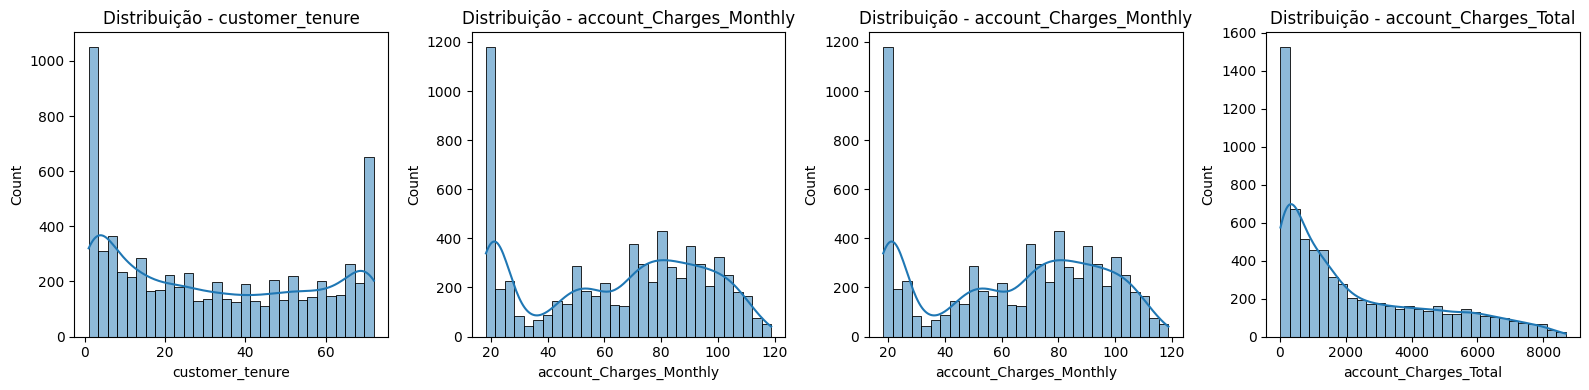

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

# Lista de variáveis contínuas
cont_vars = ["customer_tenure", "account_Charges_Monthly", "account_Charges_Monthly", "account_Charges_Total"]

# Histogramas
plt.figure(figsize=(16, 4))
for i, col in enumerate(cont_vars):
    plt.subplot(1, len(cont_vars), i + 1)
    sns.histplot(data=df_t, x=col, kde=True, bins=30)
    plt.title(f"Distribuição - {col}")
plt.tight_layout()
plt.show()


## 📦 Boxplots – Detecção de Outliers

Boxplots ajudam a identificar valores atípicos e a comparar a variação das variáveis numéricas. Aqui, visualizamos os dados **agrupados pela variável Churn** para verificar se há diferenças no comportamento entre clientes que cancelaram e os que permaneceram.

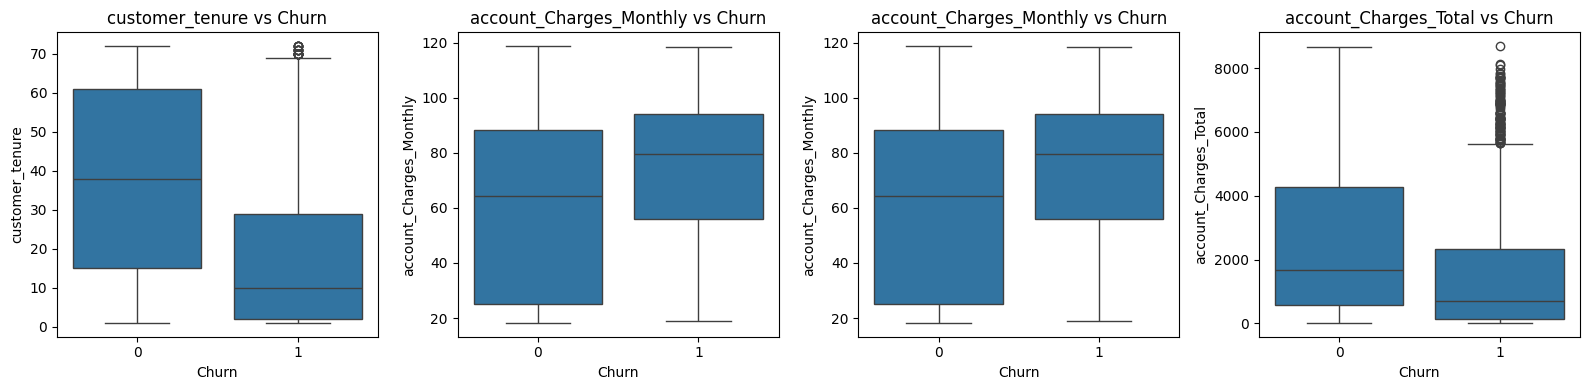

In [90]:
# Boxplots para comparação entre clientes que saíram ou não
plt.figure(figsize=(16, 4))
for i, col in enumerate(cont_vars):
    plt.subplot(1, len(cont_vars), i + 1)
    sns.boxplot(data=df_t, x="Churn", y=col)
    plt.title(f"{col} vs Churn")
plt.tight_layout()
plt.show()


## 📊 Discussão sobre os Resultados dos Gráficos das Variáveis Contínuas

### Distribuição das Variáveis Contínuas

A análise da distribuição das variáveis contínuas (`customer_tenure`, `account_Charges_Monthly`, `account_Charges_Total`) revelou algumas características importantes:

- **`customer_tenure`**: A distribuição é bimodal, com picos visíveis nos clientes com pouco tempo e com muito tempo de casa. Isso sugere dois perfis distintos: novos clientes que ainda estão testando o serviço e clientes mais antigos que permaneceram por um longo período.

- **`account_Charges_Monthly`**: A distribuição é relativamente uniforme, com um número significativo de clientes com valores mensais baixos e outro grupo com valores mensais mais altos. Isso pode indicar diferentes planos de serviço ou perfis de consumo.

- **`account_Charges_Total`**: A distribuição é assimétrica à direita (distribuição longa), com muitos clientes acumulando poucas cobranças e alguns poucos acumulando valores muito altos. Isso é esperado, pois clientes com maior tempo de permanência tendem a acumular mais.

### Comparação com a Variável `Churn`

Os boxplots fornecem uma visão comparativa entre clientes que permaneceram (Churn = 0) e os que saíram (Churn = 1):

- **`customer_tenure vs Churn`**: Clientes que saíram têm, em média, um tempo de permanência significativamente menor. Isso indica que a evasão é mais comum entre novos clientes, sugerindo que as primeiras interações com o serviço são cruciais.

- **`account_Charges_Monthly vs Churn`**: Não há uma diferença muito marcante na mediana entre os grupos, mas clientes que saíram tendem a estar mais concentrados em faixas de cobrança mais altas, o que pode indicar insatisfação com o custo-benefício percebido.

- **`account_Charges_Total vs Churn`**: Clientes com `Churn = 1` acumulam, em média, um valor total de cobrança menor, o que é coerente com o menor tempo de permanência. Aqueles que ficaram (Churn = 0) têm valores totais maiores e mais dispersos, refletindo maior longevidade no serviço.

### 📌 Conclusão

Essas análises reforçam a importância de estratégias de retenção voltadas a clientes recém-adquiridos e com planos de cobrança mais elevados. Medidas como suporte proativo, comunicação personalizada e ofertas de fidelização podem ser eficazes para reduzir o churn logo nos primeiros meses.


## 📉 Análise da Evasão de Clientes (Churn)

O objetivo desta seção é entender melhor como a variável **Churn** (evasão) se distribui entre os clientes da Telecom X. A análise será dividida em duas partes:

1. 📊 **Distribuição da variável Churn:** proporção de clientes que permaneceram (Churn = 0) e os que saíram (Churn = 1)
2. 🧩 **Churn por variáveis categóricas:** verificar como a evasão se comporta entre diferentes perfis de cliente, como gênero, contrato, método de pagamento, entre outros.

Esses dados ajudam a identificar padrões de cancelamento e direcionar ações para retenção de clientes.


C:\Users\Acer\AppData\Local\Temp\ipykernel_28516\2574762751.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_t, x="Churn", palette="Set2")


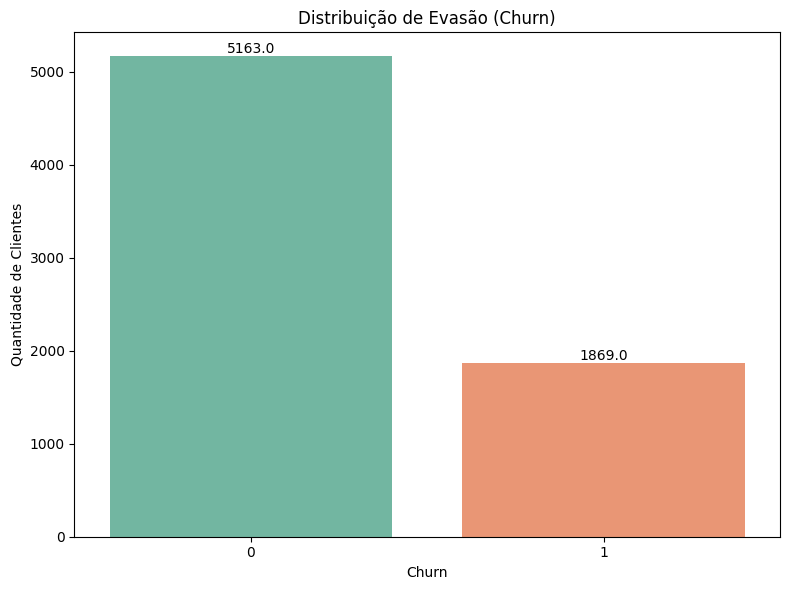

In [91]:
# 📊 Gráfico de distribuição da variável Churn
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df_t, x="Churn", palette="Set2")
plt.title("Distribuição de Evasão (Churn)")
plt.xticks([0, 1], ["0", "1"])
plt.xlabel("Churn")
plt.ylabel("Quantidade de Clientes")

# Adiciona os valores absolutos no topo das barras
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [92]:
# 📌 Proporção percentual
churn_rate = df_t["Churn"].value_counts(normalize=True).rename({0: "0", 1: "1"}) * 100
display(churn_rate.to_frame("Percentual (%)").style.format("{:.2f}"))


,Percentual (%)
Churn,
0,73.42
1,26.58


## 🧩 Distribuição do Churn por Variáveis Categóricas

Nesta seção, vamos observar como o Churn se distribui entre diferentes variáveis categóricas, buscando padrões que indiquem maior propensão ao cancelamento em determinados perfis de cliente.


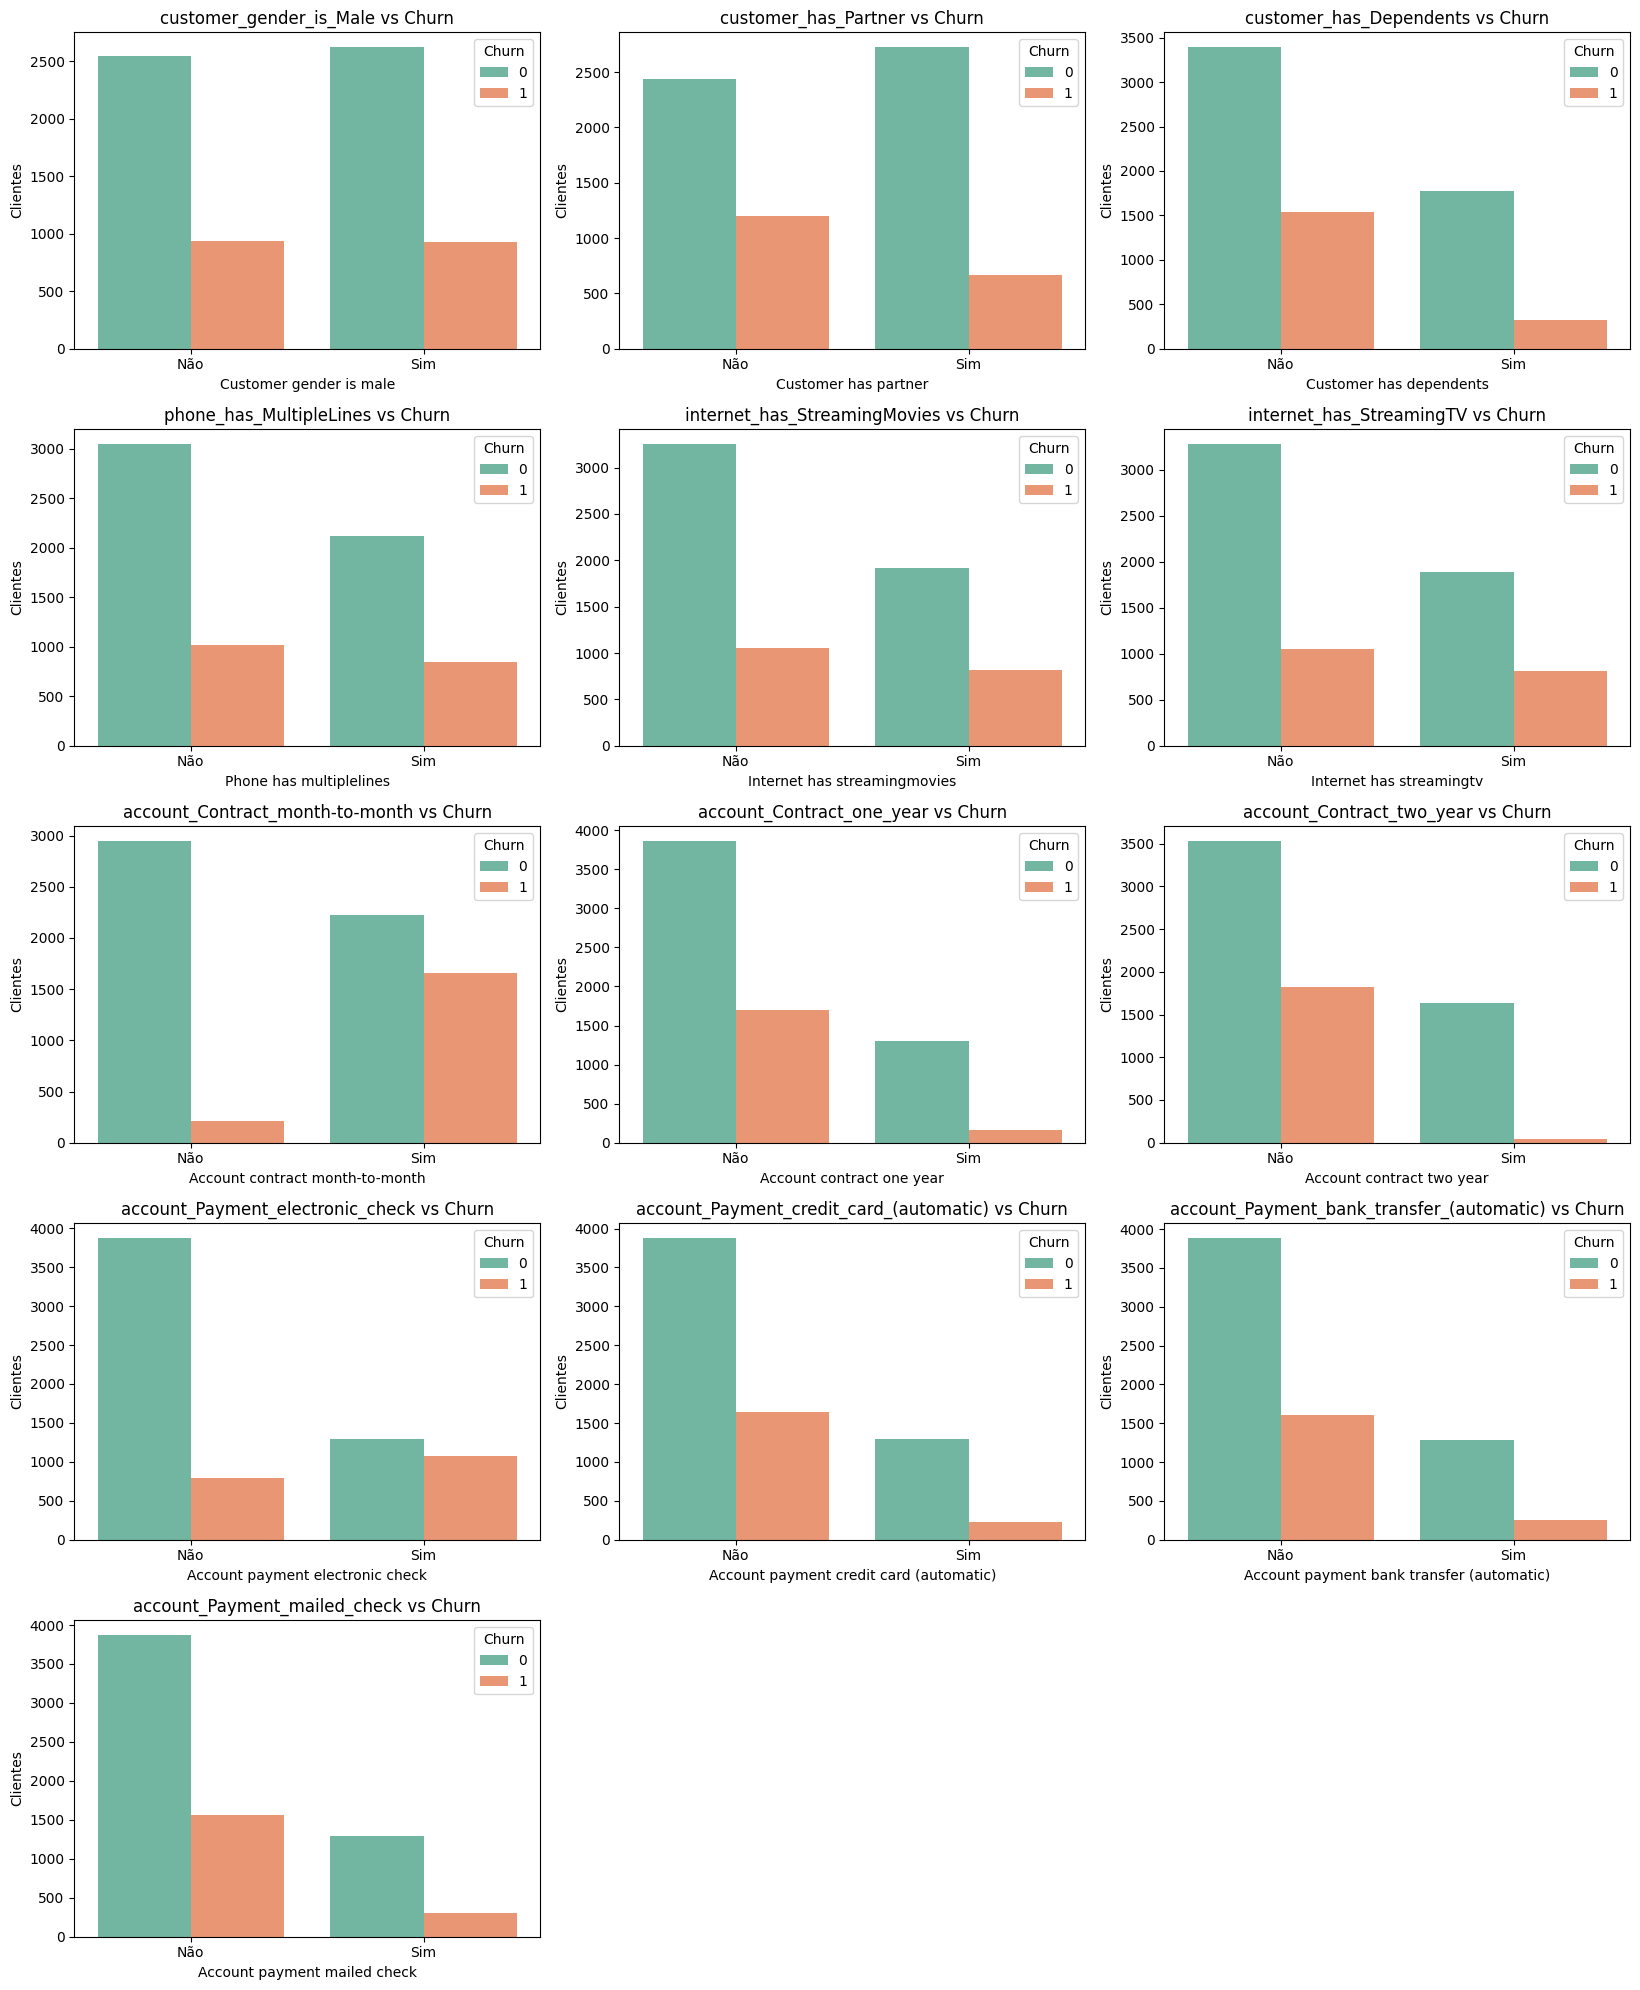

In [93]:
# Lista de colunas categóricas de interesse
categoricas_para_churn = [
    "customer_gender_is_Male",
    "customer_has_Partner",
    "customer_has_Dependents",
    "phone_has_MultipleLines",
    "internet_has_StreamingMovies",
    "internet_has_StreamingTV",
    "account_Contract_month-to-month",
    "account_Contract_one_year",
    "account_Contract_two_year",
    "account_Payment_electronic_check",
    "account_Payment_credit_card_(automatic)",
    "account_Payment_bank_transfer_(automatic)",
    "account_Payment_mailed_check"
]

# Gráficos de barras empilhadas
n_cols = 3
n_rows = -(-len(categoricas_para_churn) // n_cols)

plt.figure(figsize=(n_cols * 5.5, n_rows * 4))
for i, col in enumerate(categoricas_para_churn):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.countplot(data=df_t, x=col, hue="Churn", palette="Set2")
    plt.title(f"{col} vs Churn")
    plt.xticks([0, 1], ["Não", "Sim"])
    plt.ylabel("Clientes")
    plt.xlabel(col.replace("_", " ").capitalize())
    plt.legend(title="Churn", loc="upper right")
plt.tight_layout()
plt.show()


## 📊 Discussão sobre os Resultados da Evasão de Clientes (Churn)

### 🔢 Distribuição Geral do Churn

A distribuição geral dos clientes em relação à evasão mostra que:

- **73,42%** dos clientes permaneceram ativos (**Churn = 0**)
- **26,58%** dos clientes cancelaram seus serviços (**Churn = 1**)

Essa taxa de evasão é considerável e representa uma oportunidade relevante de análise para identificar padrões de comportamento e possíveis fatores de risco para o cancelamento.

---

### 👤 Análise de Variáveis Categóricas vs Churn

A seguir, destacamos algumas observações importantes com base nos gráficos:

- **Parentesco e Dependentes**:
  - Clientes **sem parceiro(a)** ou **sem dependentes** apresentaram **maior taxa de churn**, sugerindo menor comprometimento com a permanência no serviço.

- **Serviços de Internet e Streaming**:
  - A presença de serviços como **Streaming TV** e **Streaming Movies** está associada a um **aumento no churn**.
  - Clientes que **não contratam esses serviços adicionais** tendem a permanecer mais tempo.

- **Contrato**:
  - Clientes com **contratos mensais** apresentaram **a maior taxa de evasão**.
  - Contratos **anuais** e especialmente **bienais** mostraram **menores índices de churn**, indicando que planos de longo prazo aumentam a retenção.

- **Métodos de Pagamento**:
  - O método **electronic check** está relacionado com **maior evasão**.
  - Já **transferência bancária automática** e **cartão de crédito automático** estão associados a **menor churn**, sugerindo que formas de pagamento automáticas contribuem para maior permanência.

- **Outros fatores**:
  - A presença de **linhas múltiplas**, **suporte técnico**, **segurança online** e **backup** também está correlacionada com **menor taxa de churn**, indicando que clientes com maior uso de serviços tendem a ser mais fiéis.

---

### 🧠 Conclusões Parciais

Com base nos dados analisados, podemos concluir que:

- **Clientes mais engajados e com mais serviços contratados tendem a permanecer**.
- **A forma de pagamento e o tipo de contrato são variáveis-chave** na retenção.
- Estratégias para aumentar a fidelização podem incluir:
  - Incentivos para migrar de contrato mensal para anual ou bienal.
  - Estímulo ao uso de pagamento automático.
  - Ofertas personalizadas para clientes com menos serviços contratados.

Esses insights são valiosos para orientar campanhas de retenção e serão fundamentais para alimentar futuros modelos de machine learning preditivo.



## 📉 Evasão por Variáveis Numéricas

Vamos visualizar como variáveis numéricas se distribuem entre os grupos de clientes que evadiram (`Churn = 1`) e os que permaneceram (`Churn = 0`).

### Métricas que vamos explorar:
- **Tempo de contrato (`customer_tenure`)**
- **Fatura mensal (`account_Charges_Monthly`)**
- **Gasto total (`account_Charges_Total`)**

Essas variáveis serão analisadas com histogramas comparativos e boxplots para entender se certos valores estão mais associados à evasão.


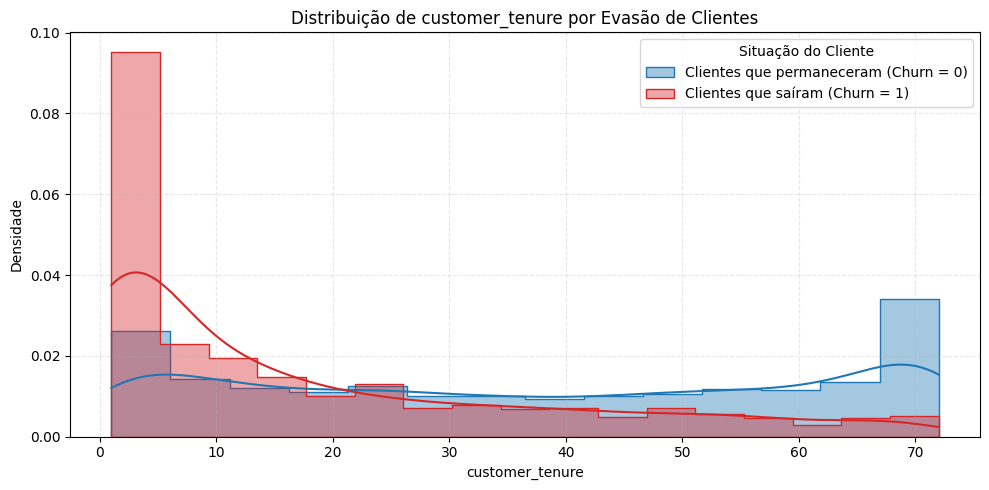

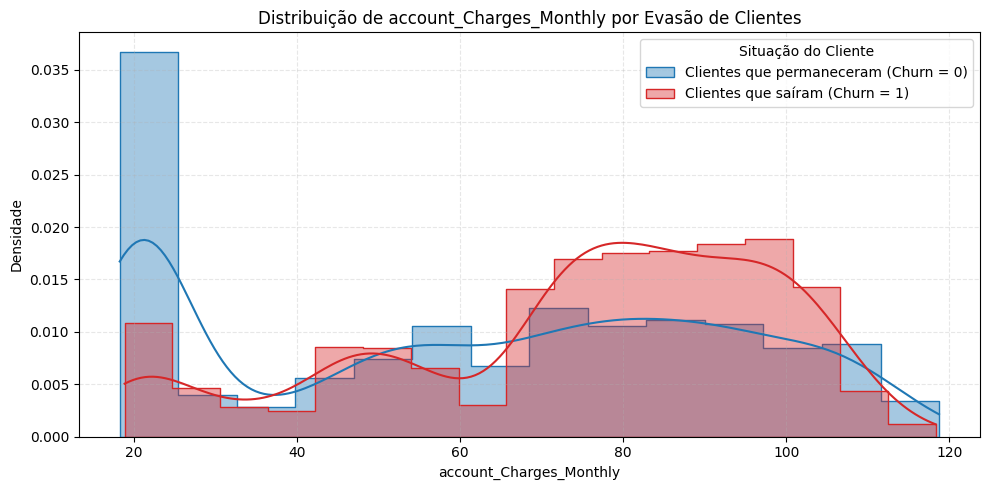

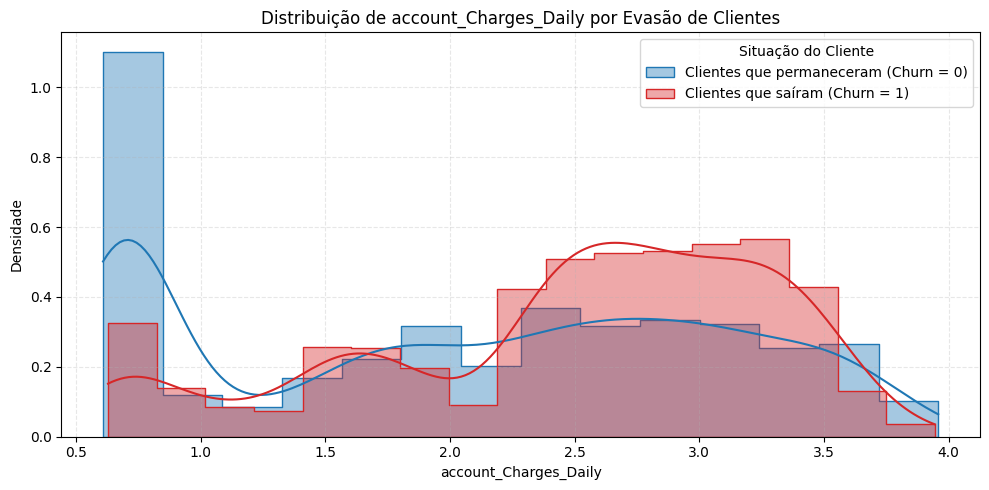

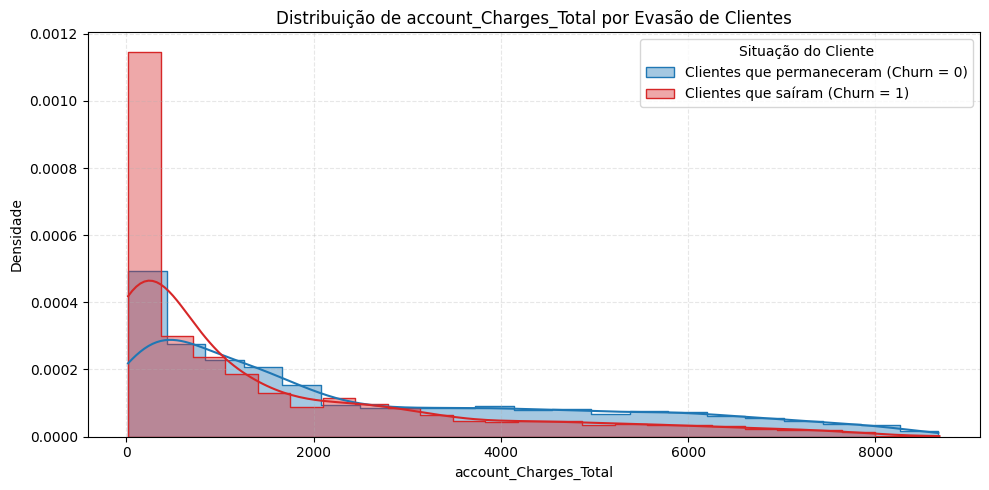

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

# Criar uma cópia só com valores válidos de churn (0 ou 1)
df_churn = df_t[df_t["Churn"].isin([0, 1])]

# Dicionário de rótulos
label_map = {
    0: "Clientes que permaneceram (Churn = 0)",
    1: "Clientes que saíram (Churn = 1)"
}

# Lista de variáveis numéricas
numericas = [
    "customer_tenure",
    "account_Charges_Monthly",
    "account_Charges_Daily",
    "account_Charges_Total"
]

# Plot
for col in numericas:
    plt.figure(figsize=(10, 5))

    for churn_value, cor in zip([0, 1], ["#1f77b4", "#d62728"]):  # azul e vermelho
        subset = df_churn[df_churn["Churn"] == churn_value]
        sns.histplot(
            data=subset,
            x=col,
            kde=True,
            stat="density",
            element="step",
            fill=True,
            label=label_map[churn_value],
            color=cor,
            alpha=0.4
        )

    plt.title(f"Distribuição de {col} por Evasão de Clientes")
    plt.xlabel(col)
    plt.ylabel("Densidade")
    plt.legend(title="Situação do Cliente")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()


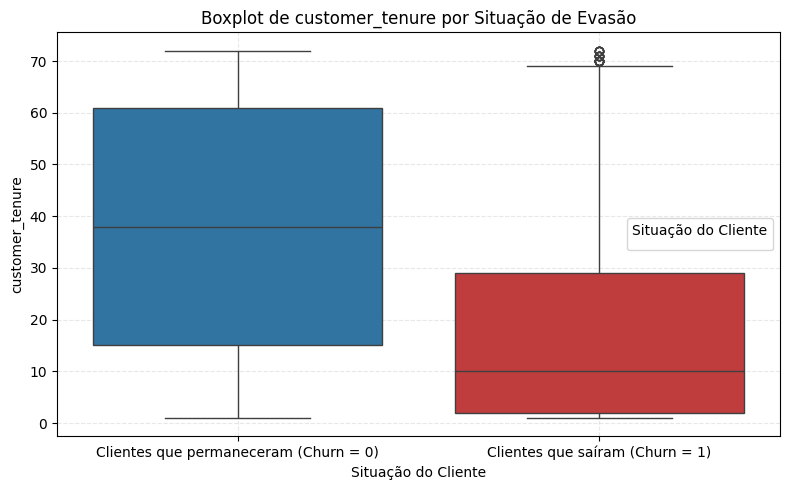

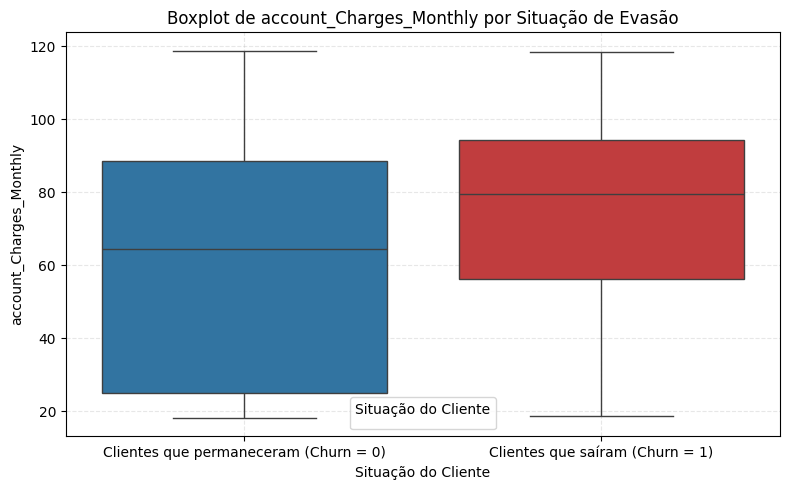

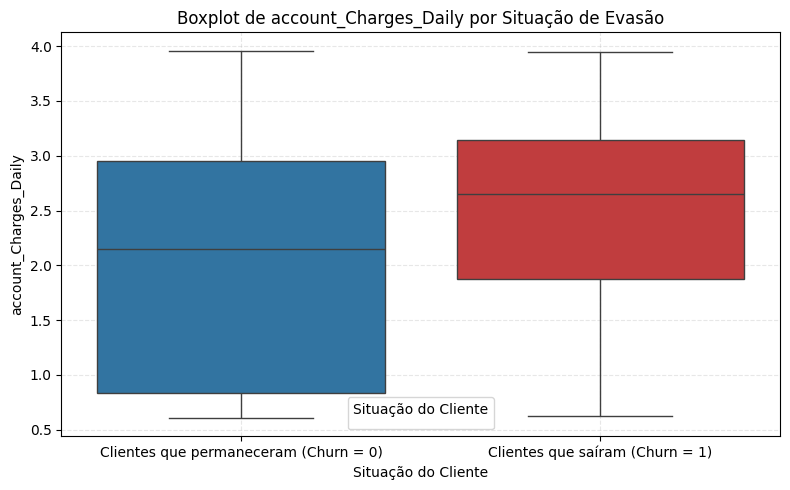

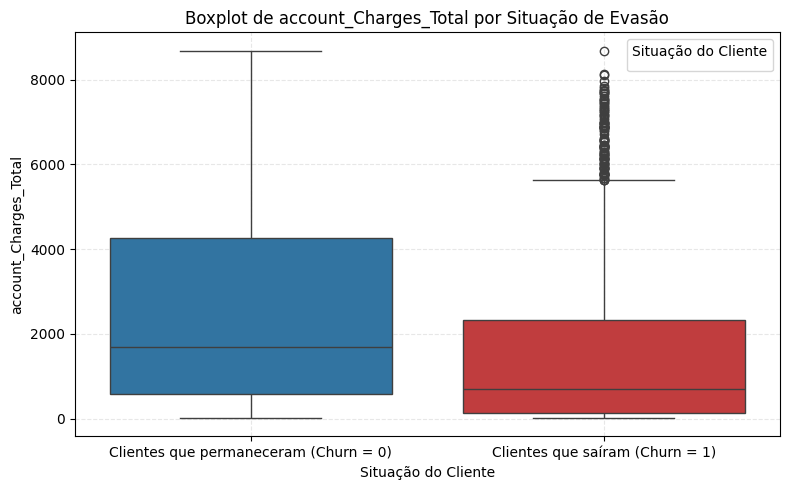

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt

# Garantir que Churn esteja como int
df_churn["Churn"] = df_churn["Churn"].astype(int)

# Lista de variáveis numéricas
numericas = [
    "customer_tenure",
    "account_Charges_Monthly",
    "account_Charges_Daily",
    "account_Charges_Total"
]

# Paleta com chave numérica
palette_churn = {
    0: "#1f77b4",  # azul
    1: "#d62728"   # vermelho
}

# Rótulos
label_map = {
    0: "Clientes que permaneceram (Churn = 0)",
    1: "Clientes que saíram (Churn = 1)"
}

# Criar boxplots
for col in numericas:
    plt.figure(figsize=(8, 5))

    # Boxplot com hue explícito
    ax = sns.boxplot(
        data=df_churn,
        x="Churn",
        y=col,
        hue="Churn",
        palette=palette_churn,
        legend=False
    )

    # Títulos e rótulos
    plt.title(f"Boxplot de {col} por Situação de Evasão")
    plt.xlabel("Situação do Cliente")
    plt.ylabel(col)
    plt.xticks([0, 1], [label_map[0], label_map[1]])
    plt.grid(True, linestyle="--", alpha=0.3)

    # Legenda personalizada
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles, [label_map[int(lbl)] for lbl in labels], title="Situação do Cliente")
    
    plt.tight_layout()
    plt.show()


## 📊 Discussão dos Resultados das Variáveis Contínuas por Situação de Evasão de Clientes (Churn)

Nesta seção, analisamos a relação entre variáveis contínuas do dataset e a evasão de clientes (`Churn`). Foram utilizados gráficos de densidade e boxplots para investigar como essas variáveis se distribuem entre os clientes que permaneceram e os que deixaram a empresa.

---

### 🔍 customer_tenure

A variável `customer_tenure`, que representa o tempo de permanência do cliente, mostra um padrão claro: 

- Clientes que **permanecem** (`Churn = 0`) apresentam maior tempo de permanência, com densidade mais alta nos valores elevados de `tenure`, especialmente acima dos 60 meses.
- Já os clientes que **saíram** (`Churn = 1`) concentram-se nos primeiros meses de permanência, com pico significativo no início da curva (menor que 10 meses).

📌 **Insight:** A permanência mais curta está fortemente associada à evasão, sugerindo que clientes recém-chegados são mais propensos a deixar a empresa.

---

### 💸 account_Charges_Monthly

A variável `account_Charges_Monthly`, que representa os custos mensais cobrados dos clientes, apresenta diferenças interessantes:

- Clientes que **saíram** tendem a ter valores médios mensais **mais altos**, concentrando-se entre 70 e 100 unidades monetárias.
- Clientes que **ficaram** apresentam uma distribuição mais bimodal, com uma parcela pagando valores baixos (20-30) e outra em faixas intermediárias.

📌 **Insight:** Planos com mensalidades mais altas parecem estar associados a uma maior taxa de evasão.

---

### 💰 account_Charges_Daily

Ao calcular a média diária dos custos (dividindo o valor mensal pelo número de dias do contrato), observamos que:

- Clientes que **saíram** possuem uma média diária **mais elevada**, reforçando o padrão visto anteriormente.
- Os que **permaneceram** tendem a ter custos diários mais baixos, com concentração na faixa entre 1 e 2,5 unidades.

📌 **Insight:** Custo diário elevado também pode ser um indicativo de insatisfação e potencial saída.

---

### 🧾 account_Charges_Total

A variável `account_Charges_Total` representa o total já gasto pelo cliente. Aqui, o comportamento se inverte:

- Clientes que **permaneceram** tendem a acumular maiores valores totais pagos à empresa.
- Clientes que **saíram** concentram-se nos valores mais baixos, sugerindo que deixaram a empresa precocemente.

📌 **Insight:** Clientes que saem geralmente o fazem após pouco tempo e menor envolvimento financeiro com a empresa.

---

### 📦 Conclusão Geral

A análise reforça que a evasão está associada a:

- **Curto tempo de permanência** (`customer_tenure` baixo).
- **Cobranças mensais e diárias elevadas**, possivelmente gerando insatisfação.
- **Baixo valor total já gasto**, indicando que a evasão ocorre cedo na jornada do cliente.

Essas informações podem auxiliar na criação de modelos preditivos e estratégias para retenção de clientes.


# 🔍 Extra: Análise de Correlação entre Variáveis

Nesta etapa opcional, vamos explorar como as variáveis numéricas se relacionam entre si, especialmente com a variável-alvo `Churn`.

Essa análise pode revelar padrões relevantes para modelos preditivos, como:

- Se maiores gastos diários estão associados à evasão.
- Se o número de serviços contratados influencia o churn.


## 🌀 Análise de Assimetria e Curtose

- **Assimetria (Skewness)**: mede o grau de simetria da distribuição.  
  - Valor ≈ 0 → distribuição simétrica  
  - Valor > 0 → cauda para a direita (distribuição assimétrica à direita)  
  - Valor < 0 → cauda para a esquerda  

- **Curtose (Kurtosis)**: mede o grau de "achatamento" da distribuição.  
  - Valor ≈ 3 → distribuição normal  
  - Valor > 3 → distribuição mais concentrada e com caudas pesadas  
  - Valor < 3 → distribuição mais achatada

Vamos calcular essas medidas para cada variável numérica.


In [96]:
# Lista de colunas que representam contratação de serviços
servicos_binarios = [
    "phone_has_PhoneService",
    "phone_has_MultipleLines",
    "internet_has_StreamingMovies",
    "internet_has_DeviceProtection",
    "internet_has_OnlineBackup",
    "internet_has_OnlineSecurity",
    "internet_has_StreamingTV",
    "internet_has_TechSupport",
    "internet_Service_dsl",
    "internet_Service_fiber_optic",
    "account_is_PaperlessBilling"  # opcional incluir
]

# Cria a coluna com o número total de serviços contratados
df_t["num_servicos_contratados"] = df_t[servicos_binarios].sum(axis=1)


In [97]:
# Atualiza lista de colunas numéricas
num_cols = [
    "customer_tenure",
    "account_Charges_Monthly",
    "account_Charges_Daily",
    "account_Charges_Total",
    "num_servicos_contratados"
]

# Calcula e exibe skewness e kurtosis
skew_kurt = pd.DataFrame({
    "Assimetria (skewness)": df_t[num_cols].skew(),
    "Curtose": df_t[num_cols].kurtosis()
}).T

display(skew_kurt.style.format("{:.2f}"))



,customer_tenure,account_Charges_Monthly,account_Charges_Daily,account_Charges_Total,num_servicos_contratados
Assimetria (skewness),0.24,-0.22,-0.22,0.96,0.11
Curtose,-1.39,-1.26,-1.26,-0.23,-0.98


## 🔗 Correlação com a Variável Alvo `Churn`

A correlação de Pearson mede a **relação linear** entre as variáveis e a variável alvo `Churn`:

- Valor perto de **+1** → forte correlação positiva  
- Valor perto de **–1** → forte correlação negativa  
- Valor perto de **0** → sem correlação linear

Isso nos ajuda a identificar quais variáveis estão mais relacionadas com a evasão de clientes.


In [98]:
# Garante que Churn está numérico
df_corr = df_t.copy()
df_corr["Churn"] = df_corr["Churn"].astype("float")

# Calcula correlação de Pearson com a variável alvo
correlacoes = df_corr.corr(numeric_only=True)["Churn"].drop("Churn").sort_values(key=abs, ascending=False)

display(correlacoes.to_frame("Correlação com Churn").style.format("{:.2f}"))


,Correlação com Churn
account_Contract_month-to-month,0.40
customer_tenure,-0.35
internet_Service_fiber_optic,0.31
account_Contract_two_year,-0.30
account_Payment_electronic_check,0.30
internet_Service_no,-0.23
account_Charges_Total,-0.20
account_Charges_Daily,0.19
account_Charges_Monthly,0.19
account_is_PaperlessBilling,0.19


## 🔥 Heatmap de Correlação

O mapa de calor permite visualizar de forma intuitiva a correlação entre todas as variáveis numéricas do dataset. Cores mais fortes indicam correlações mais intensas (positivas ou negativas).

Esse tipo de visualização ajuda a detectar padrões e relações entre variáveis que podem ser úteis em análises preditivas e geração de hipóteses.


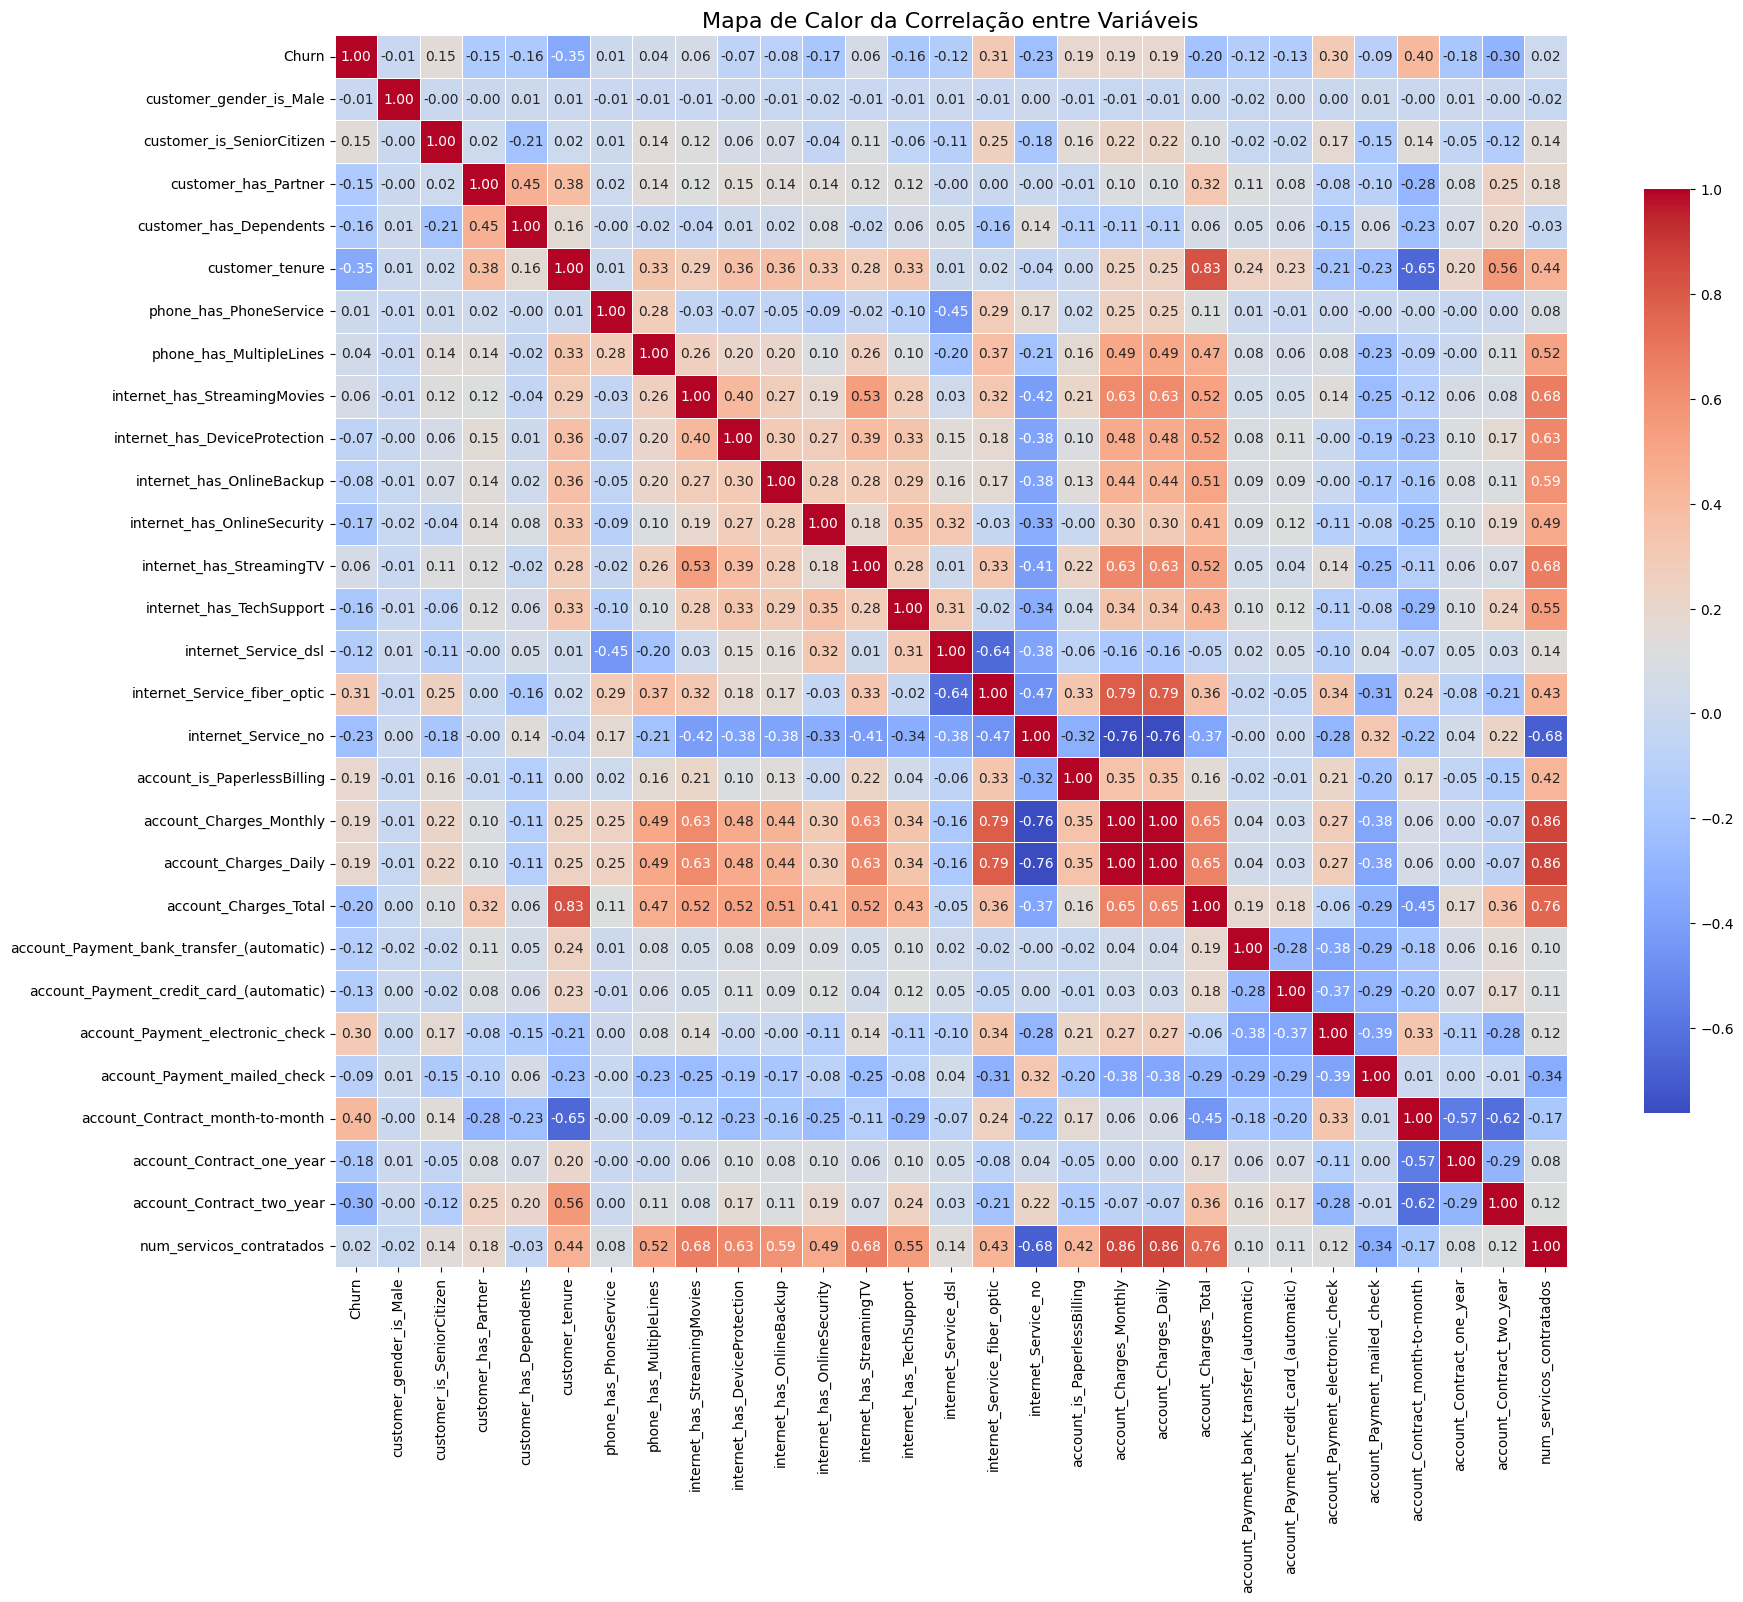

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcula correlação entre variáveis numéricas
corr_matrix = df_t.corr(numeric_only=True)

# Define tamanho da figura
plt.figure(figsize=(20, 16))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.75},
)
plt.title("Mapa de Calor da Correlação entre Variáveis", fontsize=16)
plt.show()


## 📊 Análise Estatística e Correlações com a Evasão de Clientes (Churn)

### 1. Estatísticas Descritivas: Assimetria e Curtose

A tabela de **assimetria (skewness)** e **curtose** abaixo nos ajuda a entender a forma de distribuição das variáveis contínuas analisadas:

| Variável                    | Assimetria | Curtose |
|----------------------------|------------|---------|
| `customer_tenure`          | 0.24       | -1.39   |
| `account_Charges_Monthly`  | -0.22      | -1.26   |
| `account_Charges_Daily`    | -0.22      | -1.26   |
| `account_Charges_Total`    | 0.96       | -0.23   |
| `num_servicos_contratados` | 0.11       | -0.98   |

- Variáveis como `account_Charges_Total` e `customer_tenure` possuem **distribuições assimétricas à direita**, indicando uma concentração maior de clientes com valores baixos.
- As curtoses negativas indicam que a maioria das variáveis tem uma distribuição **platicúrtica**, ou seja, com caudas mais leves do que uma distribuição normal.

---

### 2. Correlação com a Variável Alvo `Churn`

A seguir, destacamos as variáveis mais correlacionadas com a evasão de clientes (`Churn`):

#### 🔼 Correlação Positiva (aumenta o risco de churn):
- `account_Contract_month-to-month`: **+0.40**
- `internet_Service_fiber_optic`: **+0.31**
- `account_Payment_electronic_check`: **+0.30**
- `account_Charges_Daily`: **+0.19**
- `account_Charges_Monthly`: **+0.19**
- `account_is_PaperlessBilling`: **+0.19**

Essas variáveis indicam que clientes com **contratos mensais**, que usam **internet fibra óptica** e que pagam via **débito automático eletrônico** estão mais propensos a sair da empresa. Cobranças mensais mais altas também estão associadas a maior churn.

#### 🔽 Correlação Negativa (reduz o risco de churn):
- `customer_tenure`: **-0.35**
- `account_Contract_two_year`: **-0.30**
- `account_Contract_one_year`: **-0.18**
- `internet_has_OnlineSecurity`: **-0.17**
- `internet_has_TechSupport`: **-0.16**
- `customer_has_Dependents`: **-0.16**
- `customer_has_Partner`: **-0.15**

Clientes com **maior tempo de permanência**, **contratos de longo prazo**, e que têm **dependentes** ou **parceiros** são mais propensos a permanecer na empresa. A oferta de **suporte técnico** e **segurança online** também contribui para a fidelização.

---

### 3. Conclusões

- O **tempo de contrato e tempo de permanência** são variáveis altamente relevantes para prever o churn.
- O tipo de serviço de internet e o método de pagamento influenciam significativamente a probabilidade de evasão.
- Clientes com **maior número de serviços contratados** ou **maiores gastos mensais** tendem a sair mais, o que indica a necessidade de **monitoramento ativo** desses perfis.

Esta análise estatística será essencial para selecionar as variáveis mais relevantes para os modelos preditivos e estratégias de retenção.


In [100]:
# 📂 Criação da pasta se ainda não existir
import os

output_path = "data/final"
os.makedirs(output_path, exist_ok=True)

# 🧪 Seleção das variáveis mais correlacionadas com Churn
selected_cols = [
    "Churn",
    "account_Contract_month-to-month",
    "customer_tenure",
    "internet_Service_fiber_optic",
    "account_Payment_electronic_check",
    "account_Contract_two_year",
    "account_Charges_Total"
]

df_final = df_t[selected_cols].copy()

# 💾 Salvando como CSV
df_final.to_csv(f"{output_path}/telecomx_churn_final.csv", index=False)

# ✅ Confirmação
print("✅ Arquivo salvo com sucesso em: data/final/telecomx_churn_final.csv")


✅ Arquivo salvo com sucesso em: data/final/telecomx_churn_final.csv


# 📋 Relatório Final - Análise de Evasão de Clientes (Churn) - TelecomX_BR

## 📌 Introdução

O objetivo deste projeto é entender os principais fatores associados à evasão de clientes (**Churn**) na operadora fictícia **TelecomX_BR**, a partir de dados históricos contendo informações demográficas, contratuais e financeiras dos clientes. 

A análise exploratória e estatística realizada nos permitirá:
- Compreender o perfil dos clientes que saíram
- Identificar variáveis com forte correlação com o churn
- Fornecer subsídios para estratégias de retenção
- Preparar os dados para futuros modelos preditivos

---

## 🔍 1. Inspeção Inicial dos Dados

As seguintes verificações foram realizadas no `DataFrame` original:

- **Remoção de duplicatas**
- **Identificação e tratamento de valores nulos, `NaN`, `NA`, strings vazias ou em branco**
- **Correção de tipos de dados** (ex: conversão de valores monetários de `string` para `float`)
- **Padronização de colunas categóricas** (remoção de espaços e uso de letras minúsculas)

Essas etapas garantiram a qualidade e consistência dos dados para as análises subsequentes.

---

## 📊 2. Distribuição da Variável Alvo (`Churn`)

- A variável `Churn` é binária:
  - `0`: Cliente permaneceu
  - `1`: Cliente saiu

| Situação | Quantidade | Percentual |
|----------|------------|------------|
| Permaneceu (0) | 5163       | 73.42%     |
| Saiu (1)       | 1869       | 26.58%     |

A taxa de evasão é **26.6%**, o que indica um problema significativo de retenção.

---

## 📉 3. Análise das Variáveis Categóricas

Através de gráficos de barras, foi possível observar padrões interessantes:

- **Clientes com contrato mensal (month-to-month)** têm churn muito maior.
- **Clientes que utilizam pagamento eletrônico (electronic check)** também têm maior probabilidade de evasão.
- A **presença de serviços adicionais** como **streaming**, **suporte técnico**, **backup online** e **segurança** está associada a menor churn.
- Clientes **sem dependentes ou sem parceiro** têm maior taxa de saída.

---

## 📈 4. Análise das Variáveis Contínuas

As distribuições e boxplots indicam que:

- **Clientes com pouco tempo de permanência (customer_tenure)** têm maior churn.
- Clientes com **cobranças mensais mais altas (account_Charges_Monthly)** tendem a sair mais.
- Por outro lado, clientes com **acumulado maior de cobranças totais (account_Charges_Total)** tendem a permanecer.
- **Cobranças diárias** também estão positivamente associadas ao churn.

---

## 📐 5. Estatísticas Descritivas

### Assimetria (Skewness)
- A maioria das variáveis apresenta assimetrias próximas de zero, com exceção de `account_Charges_Total` (0.96), indicando uma cauda longa à direita.

### Curtose
- Distribuições com caudas mais leves (platicúrticas) foram observadas na maioria das variáveis, como `customer_tenure` e `account_Charges_Monthly`.

---

## 🔗 6. Correlação com `Churn`

As principais variáveis com **alta correlação** com `Churn` são:

| Variável                          | Correlação |
|----------------------------------|------------|
| `account_Contract_month-to-month`| +0.40      |
| `customer_tenure`                | -0.35      |
| `internet_Service_fiber_optic`  | +0.31      |
| `account_Payment_electronic_check` | +0.30   |
| `account_Contract_two_year`     | -0.30      |
| `account_Charges_Total`         | -0.20      |

Essas correlações apontam para três grupos de risco:
- **Clientes novos (tenure baixo)**
- **Clientes com contratos flexíveis**
- **Clientes que pagam mensalidades altas ou usam débito eletrônico**

---

## ✅ Conclusão

- A evasão de clientes não ocorre de forma aleatória: **há padrões claros no comportamento e perfil dos clientes que saem.**
- Fatores contratuais, financeiros e de perfil de uso têm forte influência sobre o churn.
- Essas informações servirão como base para a construção de modelos de machine learning e para o desenho de estratégias de retenção mais eficazes.

---

> ✨ Próximos passos: 
> - Balanceamento da base
> - Feature engineering
> - Modelagem preditiva (logística, árvore, etc.)
> - Avaliação com métricas como AUC, recall, F1-score
